- year to year analysis DONE
- month to month analysis DONE
- quarter to quarter analysis
- a total analysis
- VU Rides on each of the bus ride types
- monthly ridership per each route and the top 6 routes
- employee analysis (routes and yearly/monthly)
- student analysis (routes and yearly/monthly)

#
- NEW ANALYSIS IDEAS:
- create mapping: line density, traffic, student vs staff, time of day use/day of the week 
- clustering model
- predicitive model
- anomaly detection
- AM or PM rush/Weekend
- profiling
- specific yearly analysis

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.ops import substring
import gtfs_kit as gk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium  
from folium.features import DivIcon
from folium.map import Marker
import seaborn as sns
import branca

In [3]:
# Array of CSV files
csv_files = ["../csv/MoveVU_2017_2020.csv", "../csv/MoveVU_2020_2022.csv", "../csv/MoveVU_2022_Oct2023.csv"]

df1 = pd.read_csv(csv_files[0], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "RTA_COUNT", "WEGO_COUNT", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CAMPUS_ID"])

df2 = pd.read_csv(csv_files[1], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "CAMPUS_ID", "RTA_COUNT", "WEGO_COUNT"])

df3 = pd.read_csv(csv_files[2], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "CAMPUS_ID", "RTA_COUNT", "WEGO_COUNT"])

frames = [df1, df2, df3]
df = pd.concat(frames, ignore_index=True)

# Converting the "RIDE_DATE" columns to datetime objects
df['RIDE_DATE'] = pd.to_datetime(df['RIDE_DATE'])

print("Data Fields:", df.columns.values)
print("Total Number of Vanderbilt Scans in the We Go Bus System:", df.shape[0])

C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\2975803384.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_files[1], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "CAMPUS_ID", "RTA_COUNT", "WEGO_COUNT"])


Data Fields: ['CARDOFFICE_CARD_NUMBER' 'CARD_ID_STATUS' 'RIDE_DATE' 'BUS' 'ROUTE' 'RUN'
 'RT_AREA' 'RTA_COUNT' 'WEGO_COUNT' 'FIRST_NAME' 'LAST_NAME'
 'EMPLOYEE_OR_STUDENT' 'CAMPUS_ID']
Total Number of Vanderbilt Scans in the We Go Bus System: 1773392


In [4]:
# Finding the minimum and maximum dates in the dataset
min_date = df['RIDE_DATE'].min()
max_date = df['RIDE_DATE'].max()

print(min_date)
print(max_date)

2017-01-01 06:54:00+00:00
2023-09-30 22:42:19+00:00


In [5]:
# Setting up Nashville's Bus Route as a Dictionary

WEGO_FREQUENT_SERVICE = {
    3: "West_End",
    22: "Bordeaux",
    23: "Dickerson_Pike",
    50: "Charlotte_Pike",
    52: "Nolansville_Pike",
    55: "Murfreesboro_Pike",
    56: "Gallatin_Pike"
}

WEGO_LOCAL_SERVICE = {
    4: "Shelby",
    6: "Lebanon_Pike",
    7: "Hillsboro_Pike",
    8: "8th_Avenue_South",
    9: "MetroCenter",
    14: "Whites_Creek",
    17: "12th_Avenue_South",
    18: "Airport",
    19: "Herman",
    28: "Meridian",
    29: "Jefferson",
    34: "Opry Mills",
    41: "Golden Valley",
    42: "St._Cecilia/Cumberland"
}

WEGO_CONNECTOR_SERVICE = {
    70: "Bellevue",
    75: "Midtown",
    76: "Madison",
    77: "Thompson/Wedgewood",
    79: "Skyline"
}

WEGO_EXPRESS_SERVICE = {
    84: "Murfreesboro",
    86: "Smyrna/La_Vergne",
    87: "Gallatin/Hendersonville",
    88: "Dickson",
    89: "Springfield/Joelton",
    94: "Clarksville",
    95: "Spring_Hill/Franklin"
}

# TODO need to find the number for the train system and other missing routes
WEGO_TRAIN_SERVICE = {
    64: "Star_Downtown_Shuttle",
    93: "Star_West_End_Shuttle"
}

WEGO_ALL_ROUTES = {**WEGO_FREQUENT_SERVICE, **WEGO_LOCAL_SERVICE, **WEGO_CONNECTOR_SERVICE, **WEGO_EXPRESS_SERVICE, **WEGO_TRAIN_SERVICE}
list_WE_GO_ALL_ROUTES = list(WEGO_ALL_ROUTES.keys())
list_WE_GO_ALL_ROUTES.sort()
print("Listed Routes:", list_WE_GO_ALL_ROUTES)
print("Number of Routes:", len(list_WE_GO_ALL_ROUTES))


# checking unique routes from the data
unique_routes = list(df['ROUTE'].unique())
unique_routes.sort()
print("Unique Routes:", unique_routes)
set_unique_routes = set(unique_routes)
print("Number of Unique Routes:", len(set_unique_routes))
# seeing what routes are missing from the dictionary
missing_routes_set = set_unique_routes - set(list_WE_GO_ALL_ROUTES)
missing_routes = list(missing_routes_set)
missing_routes.sort()
print("Missing Routes:", missing_routes)
print("Number of Missing Routes:", len(missing_routes))


# Possible Explanation for Missing Routes:
# Missing Routes: [16, 27, 47, 48, 59, 97, 98, 99]
# 16: Old Hickory - Independent section became part of an extended 36 Madison Square
# 16: Madison/Old Hickory - Created on August 10, 2003; eliminated due to budget crisis; service restored in Madison on September 26, 2010, as 76 Madison Connector; rest restored on April 30, 2012, as 27 Old Hickory (eastern portion) and 36 Madison Express (western portion)
# 27: Opryland Hotel
# 27: Old Hickory
# 47: 
# 48:
# 59:
# 97:
# 98:
# 99:

Listed Routes: [3, 4, 6, 7, 8, 9, 14, 17, 18, 19, 22, 23, 28, 29, 34, 41, 42, 50, 52, 55, 56, 64, 70, 75, 76, 77, 79, 84, 86, 87, 88, 89, 93, 94, 95]
Number of Routes: 35
Unique Routes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 55, 56, 59, 60, 61, 64, 70, 72, 73, 75, 76, 77, 78, 79, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 180, 181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 302, 303, 304, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 350, 352, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 

Total VU Rides on WeGo - year to year comparison (2017 - 2023)


List of Unique Years [2017, 2018, 2019, 2020, 2021, 2022, 2023]
YEAR
2017    232946
2018    218884
2019    419448
2020    166313
2021    194829
2022    286060
2023    254912
Name: Rides Per Year, dtype: int64


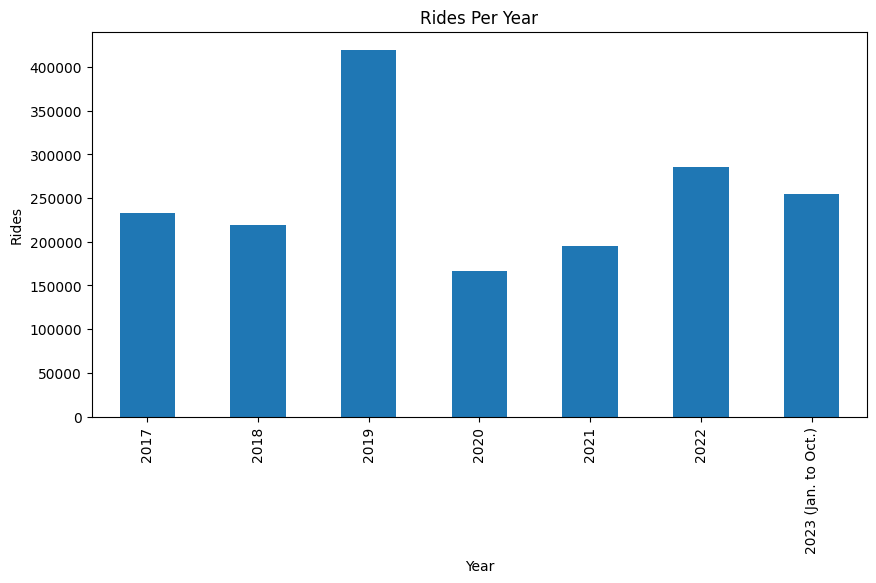

In [6]:
# yearly analysis of the data (2017 - October 2023)
# 2017: 1, 2018: 2, 2019: 3, 2020: 4, 2021: 5, 2022: 6, 2023: 7

# total VU Rides on WeGo - month to month comparison (2017 - October 2023)
print("Total VU Rides on WeGo - year to year comparison (2017 - 2023)")

# Extract the sum the year and month from the "RIDE_DATE" column
df['YEAR'] = df['RIDE_DATE'].dt.year

year_list = list(df['YEAR'].unique())
year_list.sort()

print("List of Unique Years", year_list)

# TODO: COMMENT THIS FUNCTION
def plot_all_years(rides):
    # set the header to "Total Rides"
    rides = rides.rename("Rides Per Year")
    print(rides)

    # Visualize the data
    plt.figure(figsize=(10, 5))
    rides.plot.bar()
    plt.title("Rides Per Year")
    plt.xlabel("Year")
    plt.ylabel("Rides")
    plt.xticks(range(len(rides)), ['2017', '2018', '2019', '2020', '2021', '2022', '2023 (Jan. to Oct.)'])
    plt.show()


# Group the data by year and calculate the total number of rides per month
all_yearly_rides = df.groupby('YEAR')['RIDE_DATE'].count()
plot_all_years(all_yearly_rides)

Monthly Analysis of the Data (2017 - Sept 2023)


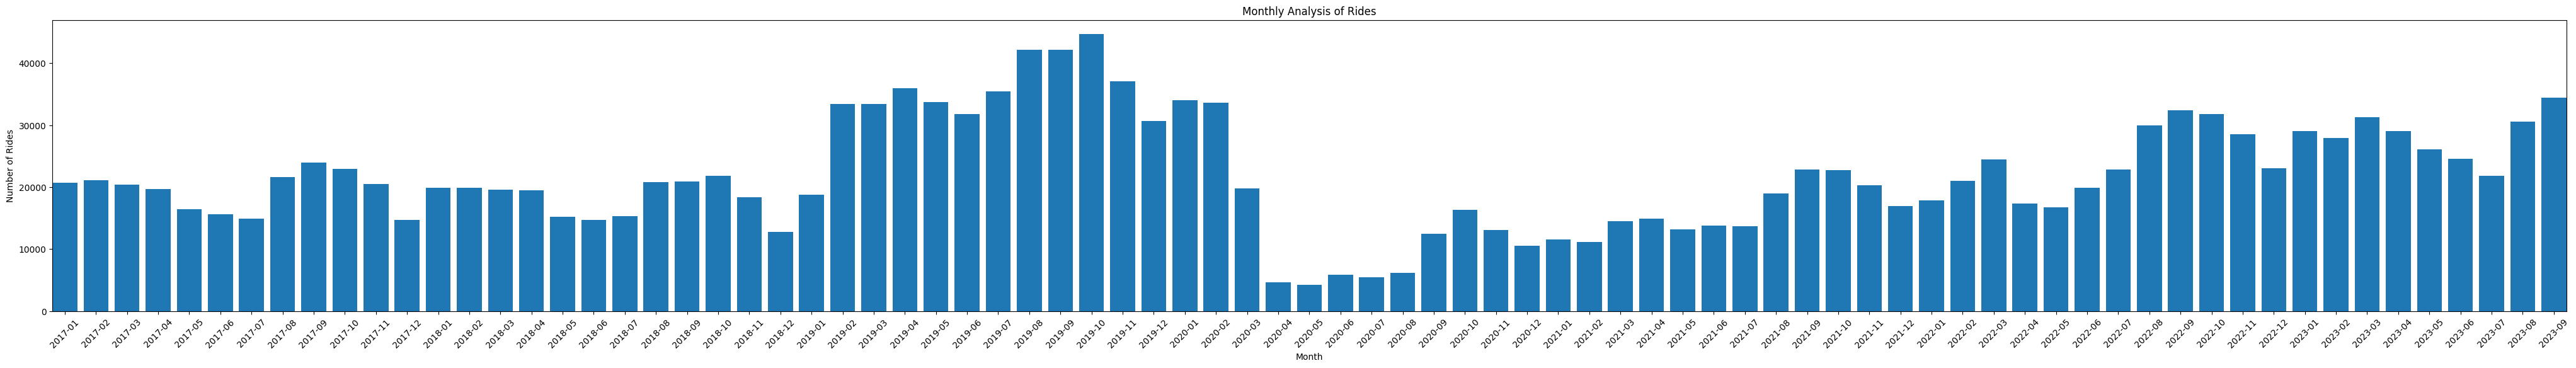

In [7]:
# monthly analysis of the data (2017 - October 2023)
print("Monthly Analysis of the Data (2017 - Sept 2023)")

# Extract month and year and create a new column
df['MONTH_YEAR'] = df['RIDE_DATE'].dt.strftime('%Y-%m')
# print(len(df['MONTH_YEAR'].unique()))


# print(monthly_data['MONTH_YEAR'].unique())

def plot_all_months(monthly_data):
    # Create a bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_data['MONTH_YEAR'], monthly_data['RIDE_COUNT'])
    plt.xlabel('Month')
    plt.ylabel('Number of Rides')
    plt.title('Monthly Analysis of Rides')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*(len(monthly_data))+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

    # plt.savefig(__file__+".png")
    plt.show()

# Group the data by 'Month_Year' and count the number of rides per month
monthly_data = df.groupby('MONTH_YEAR').size().reset_index(name='RIDE_COUNT')
plot_all_months(monthly_data)


In [8]:
# quarterly analysis of the data (2017 - October 2023)

Monthly Route Analysis
All VU Ridership by Routes, including changes from Feb. 2023 to Apr. 2023


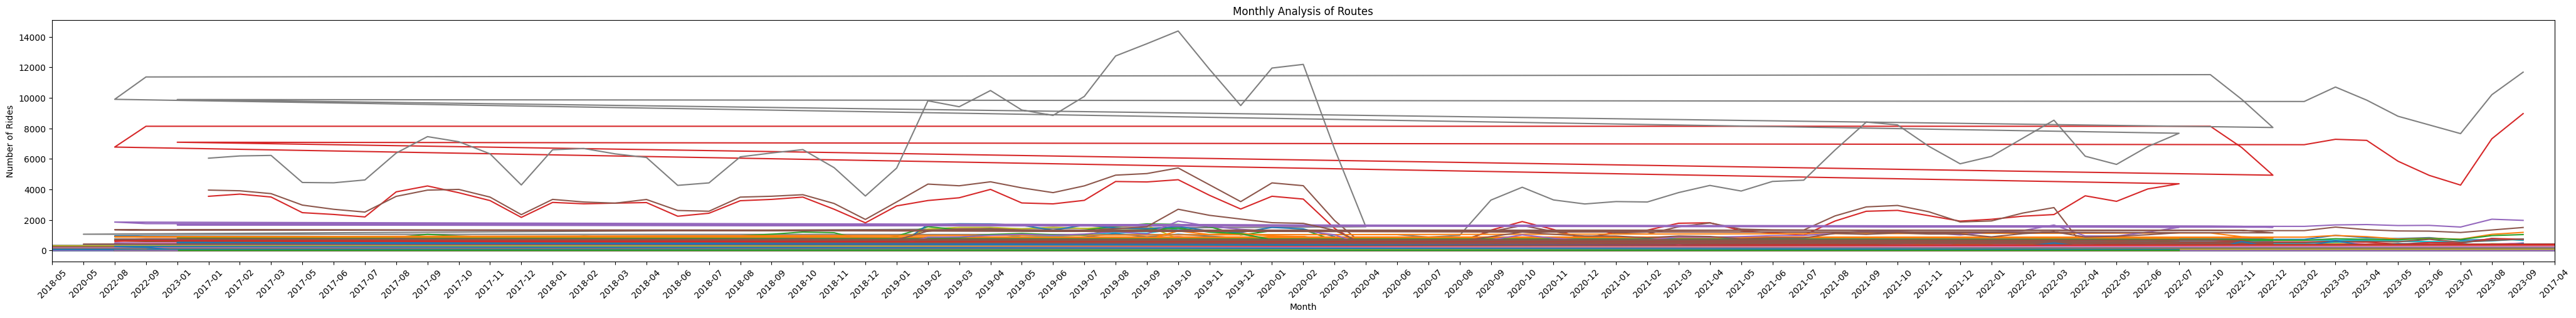

Top 6 Routes by Ridership from 2017 to Oct. 2023
    ROUTE  RIDERSHIP
7       7     550653
3       3     263013
5       5     169718
45     56      81985
44     55      74596
22     25      50782


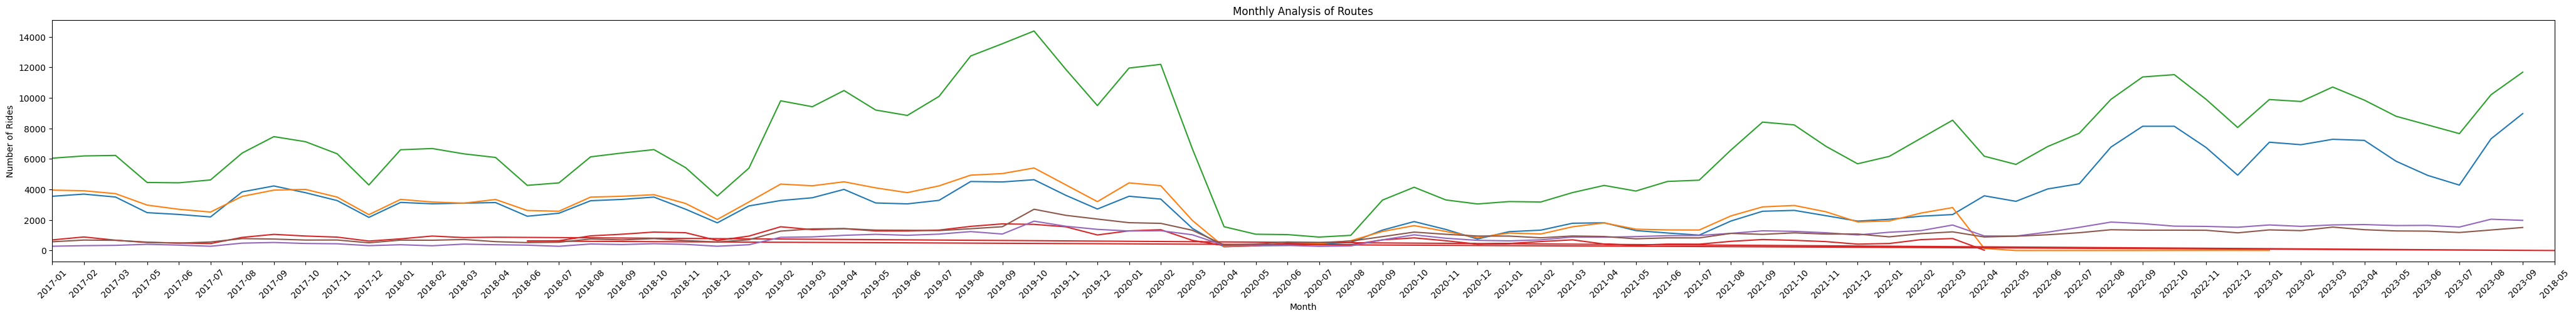

In [9]:
# plotting monthly route analysis
print("Monthly Route Analysis")
def plot_top_and_all_routes(route_month_counts):
    # graph all the routes
    plt.figure(figsize=(10, 5))
    for route in route_month_counts['ROUTE'].unique():
        if route in WEGO_ALL_ROUTES:
            route_data = route_month_counts[route_month_counts['ROUTE'] == route]
            plt.plot(route_data['MONTH_YEAR'], route_data['COUNT'], label=(str(route) +": " + WEGO_ALL_ROUTES[route]))
        else:
            route_data = route_month_counts[route_month_counts['ROUTE'] == route]
            plt.plot(route_data['MONTH_YEAR'], route_data['COUNT'], label=(str(route) +": " + "Missing Route"))

    plt.xlabel('Month')
    plt.ylabel('Number of Rides')
    plt.title('Monthly Analysis of Routes')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*(len(monthly_data))+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

    # plt.savefig(__file__+".png")
    plt.show()


    # Top 6 Routes by Total Ridership

    # Calculate the total ridership for each route
    route_ridership = route_month_counts.groupby('ROUTE')['COUNT'].sum().reset_index(name='RIDERSHIP')
    # Find the top 6 routes by total ridership
    top_6_routes = route_ridership.sort_values('RIDERSHIP', ascending=False).head(6)
    print("Top 6 Routes by Ridership from 2017 to Oct. 2023")
    print(top_6_routes)

    # Make a list of the top 6 routes
    top_6_routes_list = list(top_6_routes['ROUTE'])

    # Plot the top 6 routes
    plt.figure(figsize=(10, 5))
    for route in route_month_counts['ROUTE'].unique():
        if route in top_6_routes_list:
            if route in WEGO_ALL_ROUTES:
                route_data = route_month_counts[route_month_counts['ROUTE'] == route]
                plt.plot(route_data['MONTH_YEAR'], route_data['COUNT'], label=(str(route) +": " + WEGO_ALL_ROUTES[route]))
            else:
                route_data = route_month_counts[route_month_counts['ROUTE'] == route]
                plt.plot(route_data['MONTH_YEAR'], route_data['COUNT'], label=(str(route) +": " + "Missing Route"))

    plt.xlabel('Month')
    plt.ylabel('Number of Rides')
    plt.title('Monthly Analysis of Routes')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*(len(monthly_data))+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

    # plt.savefig(__file__+".png")
    plt.show()


# - All VU Ridership by Routes, including changes over time
print("All VU Ridership by Routes, including changes from Feb. 2023 to Apr. 2023")

# Calculate the total ridership for each route per month - Using MONTH and RIDE_DATE FROM ABOVE
total_route_month_count = df.groupby(['ROUTE', 'MONTH_YEAR']).size().reset_index(name='COUNT')

plot_top_and_all_routes(total_route_month_count)

In [10]:
# Total VU Rides on WeGo by University Roles (Faculty, Staff Grad/Professional, Undergrad)
#   By class, Freshman, Sophomore, etc.
#   By school
#   By division

# TODO: Figure out how to get more information on the person - probably from the vunet
# Total VU Rides on WeGo by Student/Employee/Other
print("Total VU Rides on WeGo by Student/Employee from Feb. 2023 to Apr. 2023")


# Data Cleaning First!
# remove rows with missing employee_or_student, campus_id, first_name, last_name or CARD_ID_STATUS = UNKOWN
# ['CARDOFFICE_CARD_NUMBER' 'CARD_ID_STATUS' 'RIDE_DATE' 'BUS' 'ROUTE' 'RUN'
#  'RT_AREA' 'RTA_COUNT' 'WEGO_COUNT' 'FIRST_NAME' 'LAST_NAME'
#  'EMPLOYEE_OR_STUDENT' 'CAMPUS_ID']
columns_to_check = ['CAMPUS_ID', 'FIRST_NAME', 'LAST_NAME', 'EMPLOYEE_OR_STUDENT']
df_cleaned = df.dropna(subset=columns_to_check)

# Check how many entries remain
print("Total Number of Vanderbilt Scans in the We Go Bus System (Pre-Clean):", df.shape[0])
print("Total Number of Vanderbilt Scans in the We Go Bus System (Clean):", df_cleaned.shape[0])

# print whats the unique values in the employee_or_student column
print("Unique Values in the Employee or Student Column:", df_cleaned['EMPLOYEE_OR_STUDENT'].unique())

# print number of students
df_students = df_cleaned[df_cleaned['EMPLOYEE_OR_STUDENT'] == 'STUDENT']
print("Total Number of Vanderbilt Student Scans in the We Go Bus System (Clean):", df_students.shape[0])

# print number of employees
df_employees = df_cleaned[df_cleaned['EMPLOYEE_OR_STUDENT'] == 'EMPLOYEE']
print("Total Number of Vanderbilt Employee Scans in the We Go Bus System (Clean):", df_employees.shape[0])

df_other = df_cleaned[df_cleaned['EMPLOYEE_OR_STUDENT'] == 'OTHER']
print("Total Number of Vanderbilt Other Scans in the We Go Bus System (Clean):", df_other.shape[0])

# print total number of scans
print("Total Number of Vanderbilt Scans in the We Go Bus System (Clean):", df_cleaned.shape[0])

print(df_employees.shape[0] + df_students.shape[0] + df_other.shape[0])
# Student Month Comparsion
# Student Route Comparsion

# Other Month Comparsion
# Other Route Comparsion

Total VU Rides on WeGo by Student/Employee from Feb. 2023 to Apr. 2023
Total Number of Vanderbilt Scans in the We Go Bus System (Pre-Clean): 1773392
Total Number of Vanderbilt Scans in the We Go Bus System (Clean): 1181180
Unique Values in the Employee or Student Column: ['STUDENT' 'EMPLOYEE' 'OTHER']
Total Number of Vanderbilt Student Scans in the We Go Bus System (Clean): 216404
Total Number of Vanderbilt Employee Scans in the We Go Bus System (Clean): 957324
Total Number of Vanderbilt Other Scans in the We Go Bus System (Clean): 7452
Total Number of Vanderbilt Scans in the We Go Bus System (Clean): 1181180
1181180


Employee VU Rides on WeGo - month to month comparison (2017 to Oct. 2023)
Total Number of Vanderbilt Employee Scans in the We Go Bus System (Clean): 957324


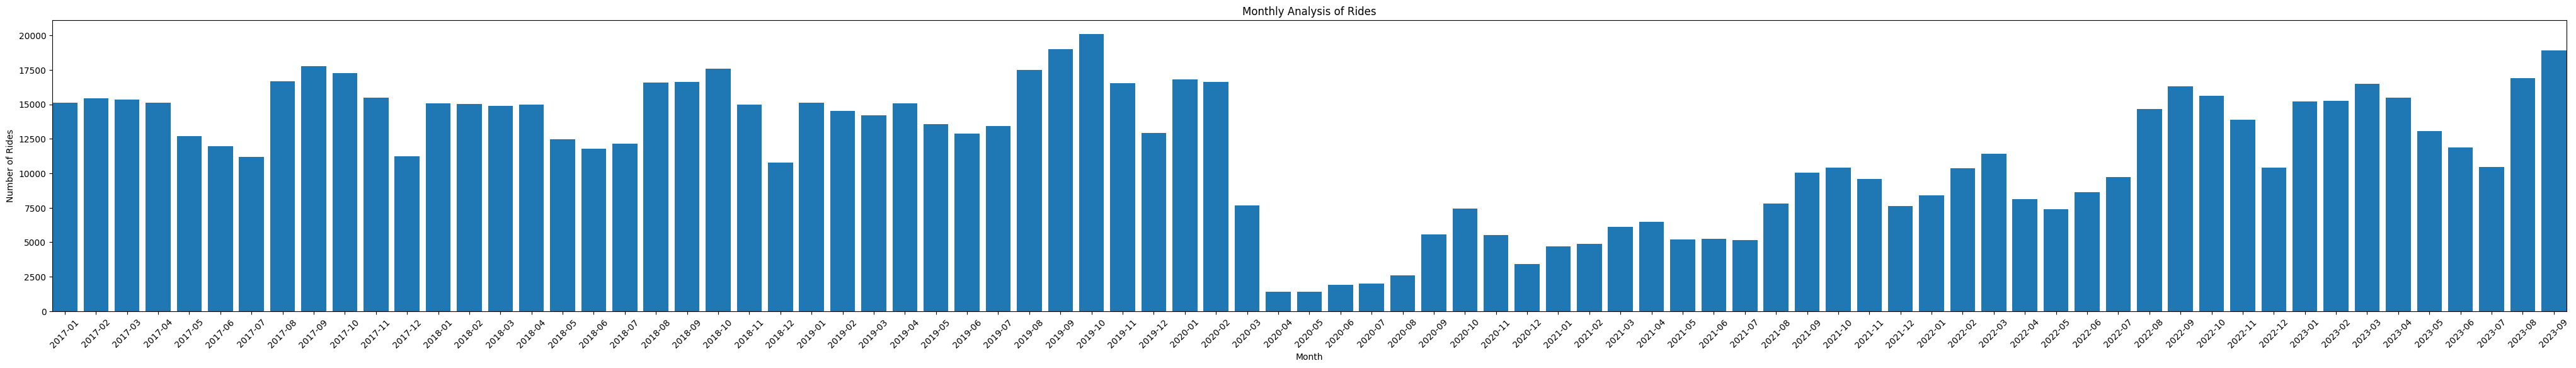

Employee Route Comparsion - All Routes and Top 6 Routes


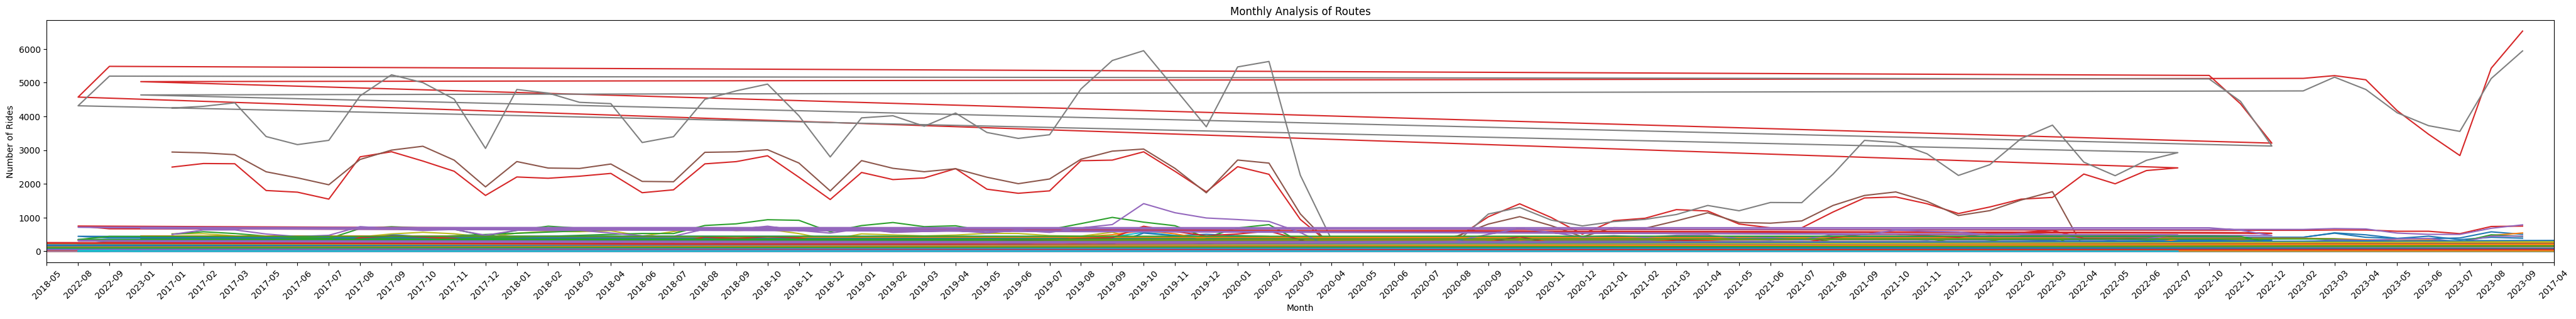

Top 6 Routes by Ridership from 2017 to Oct. 2023
    ROUTE  RIDERSHIP
7       7     267287
3       3     180205
5       5     114234
44     56      45341
43     55      31469
22     25      30790


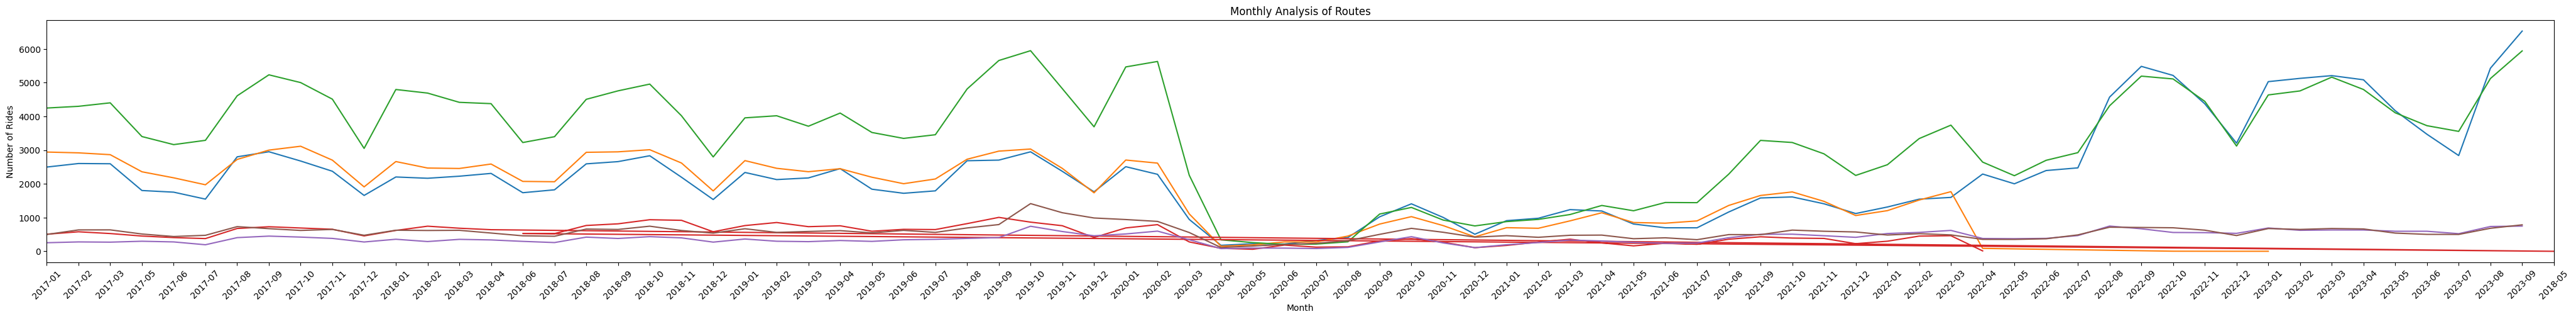

In [11]:
# Employee Month Comparsion

# total VU Rides on WeGo - month to month comparison (February - April 2023)
print("Employee VU Rides on WeGo - month to month comparison (2017 to Oct. 2023)")

print("Total Number of Vanderbilt Employee Scans in the We Go Bus System (Clean):", df_employees.shape[0])

# Group the data by 'Month_Year' and count the number of rides per month, for employees only
monthly_data = df_employees.groupby('MONTH_YEAR').size().reset_index(name='RIDE_COUNT')
plot_all_months(monthly_data)

# Employee Route Comparsion - All Routes and Top 6 Routes
print("Employee Route Comparsion - All Routes and Top 6 Routes")
# Calculate the total ridership for each route per month - Using MONTH and RIDE_DATE FROM ABOVE
route_month_counts = df_employees.groupby(['ROUTE', 'MONTH_YEAR']).size().reset_index(name='COUNT')

# Visualize the Data
plot_top_and_all_routes(route_month_counts)

Total Number of Vanderbilt Employee Scans in the We Go Bus System (Clean): 216404
Student VU Rides on WeGo - month to month comparison (2017 to Oct. 2023)


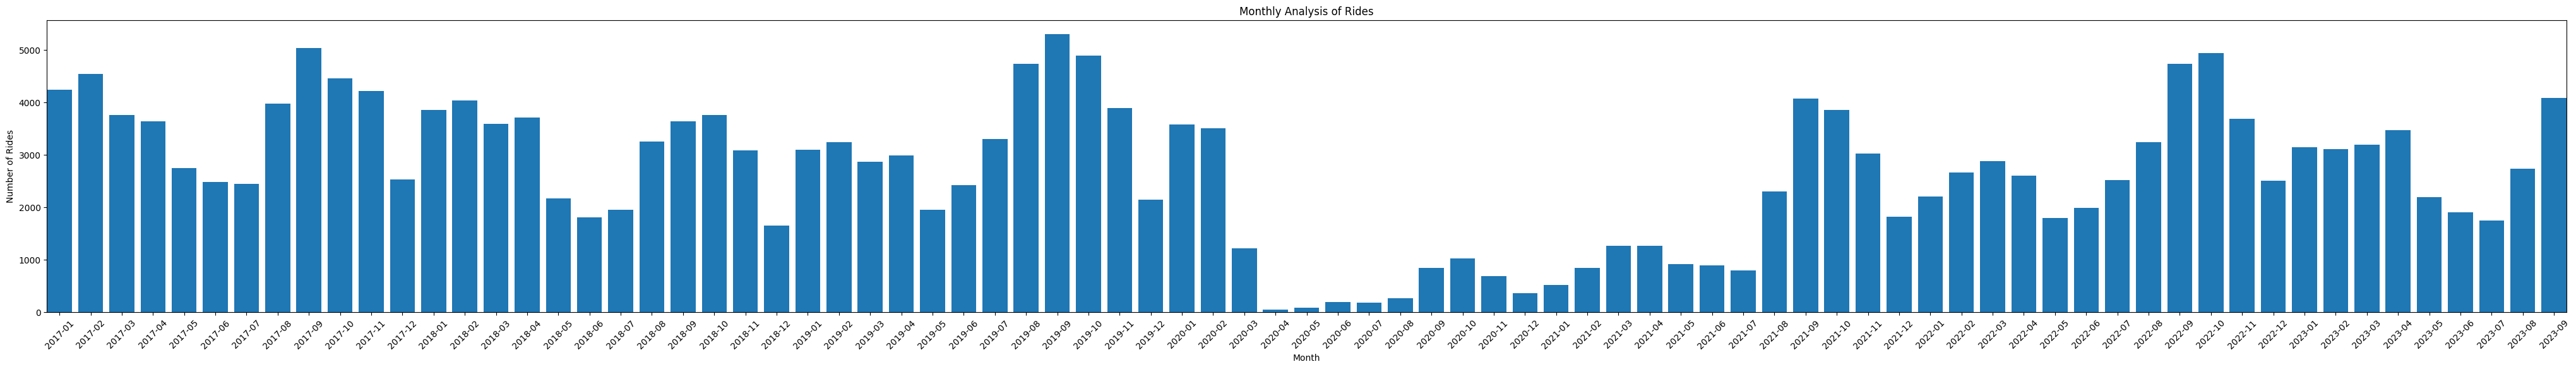

Employee Route Comparsion - All Routes and Top 6 Routes


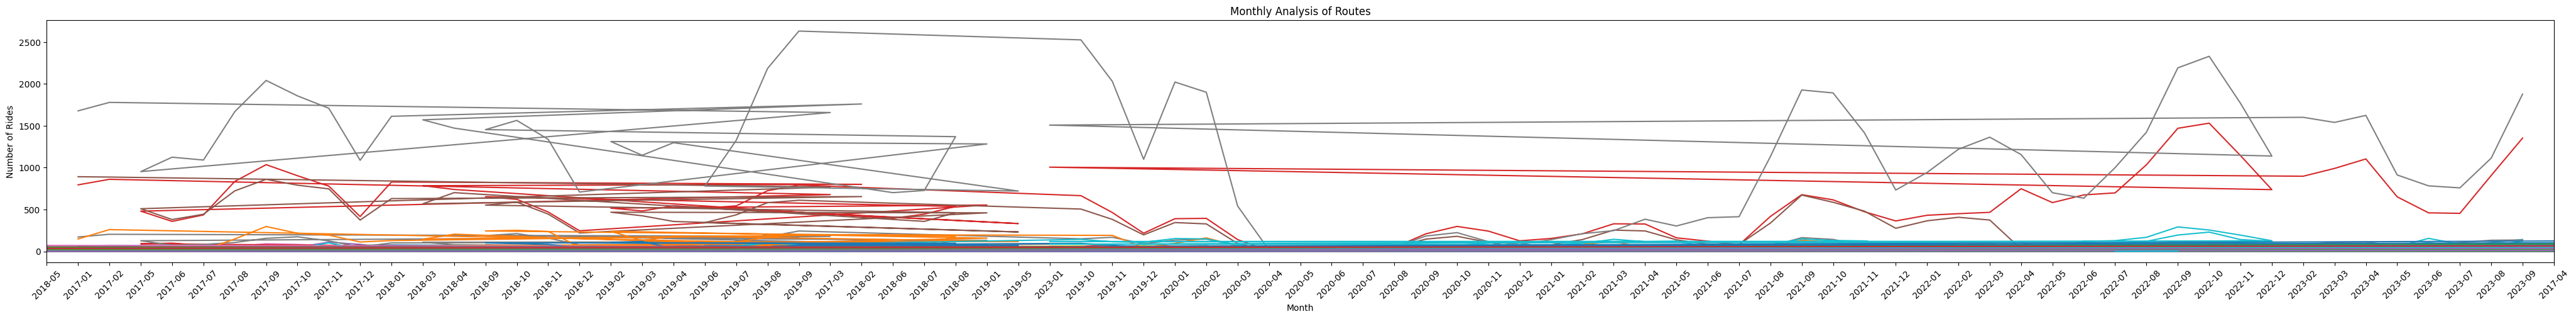

Top 6 Routes by Ridership from 2017 to Oct. 2023
    ROUTE  RIDERSHIP
7       7      91236
3       3      44054
5       5      23810
21     25       6642
17     21       5974
39     50       5876


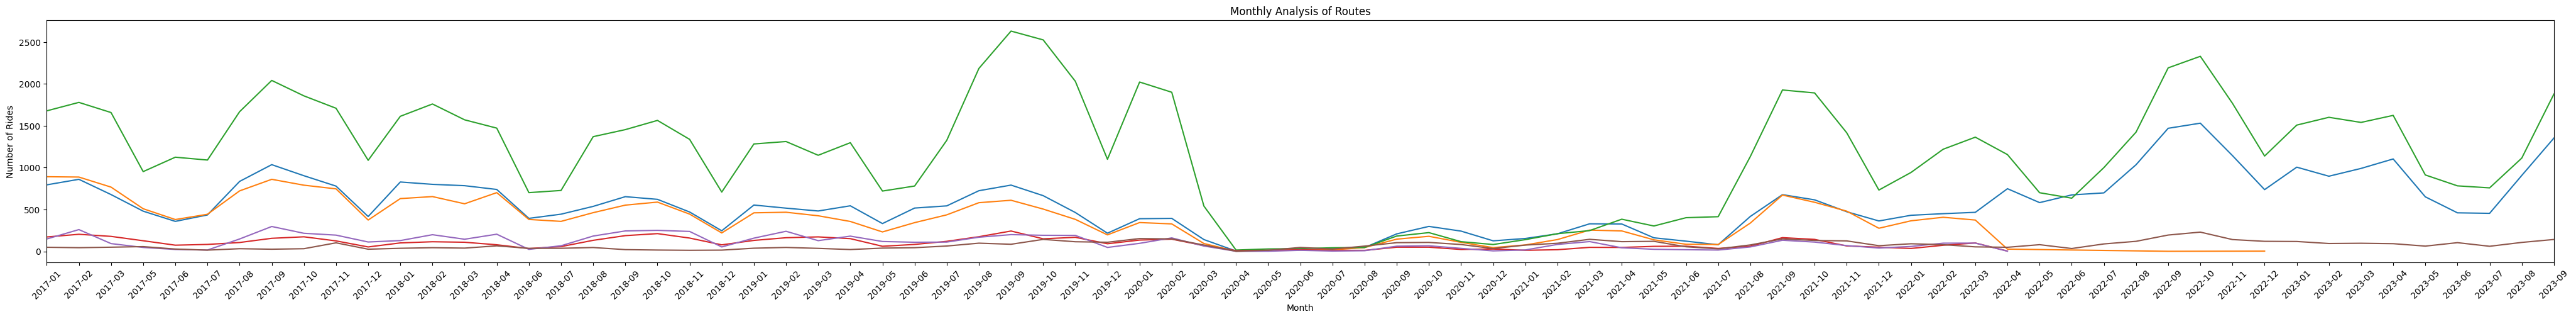

In [12]:
# Student Month Comparsion

# total VU Rides on WeGo - month to month comparison (February - April 2023)
print("Total Number of Vanderbilt Employee Scans in the We Go Bus System (Clean):", df_students.shape[0])
print("Student VU Rides on WeGo - month to month comparison (2017 to Oct. 2023)")

# Group the data by 'Month_Year' and count the number of rides per month, for employees only
monthly_data = df_students.groupby('MONTH_YEAR').size().reset_index(name='RIDE_COUNT')
plot_all_months(monthly_data)

# Employee Route Comparsion - All Routes and Top 6 Routes
print("Employee Route Comparsion - All Routes and Top 6 Routes")
# Calculate the total ridership for each route per month - Using MONTH and RIDE_DATE FROM ABOVE
route_month_counts = df_students.groupby(['ROUTE', 'MONTH_YEAR']).size().reset_index(name='COUNT')

# Visualize the Data
plot_top_and_all_routes(route_month_counts)

Total Number of Vanderbilt Other Scans in the We Go Bus System (Clean): 7452
Student VU Rides on WeGo - month to month comparison (2017 to Oct. 2023)


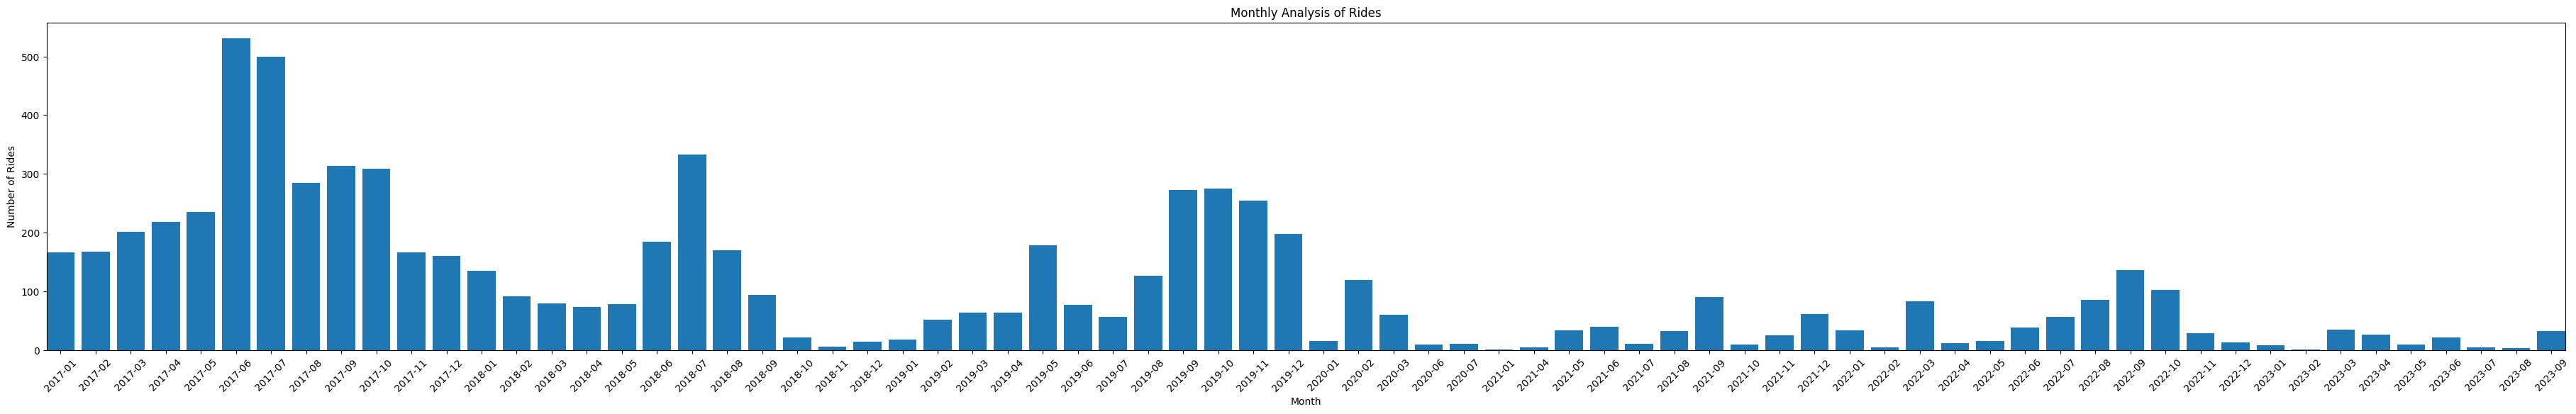

Employee Route Comparsion - All Routes and Top 6 Routes


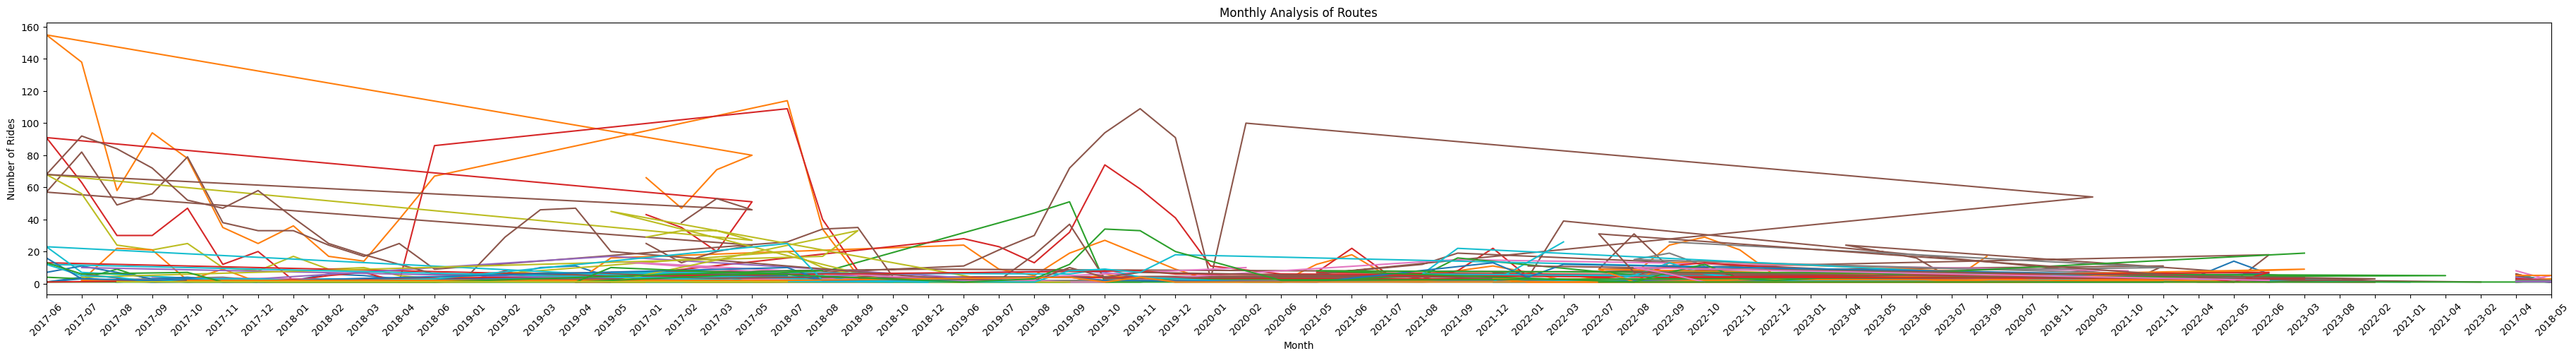

Top 6 Routes by Ridership from 2017 to Oct. 2023
    ROUTE  RIDERSHIP
5       7       1543
1       3       1513
3       5       1086
15     21        937
8      10        456
32     56        218


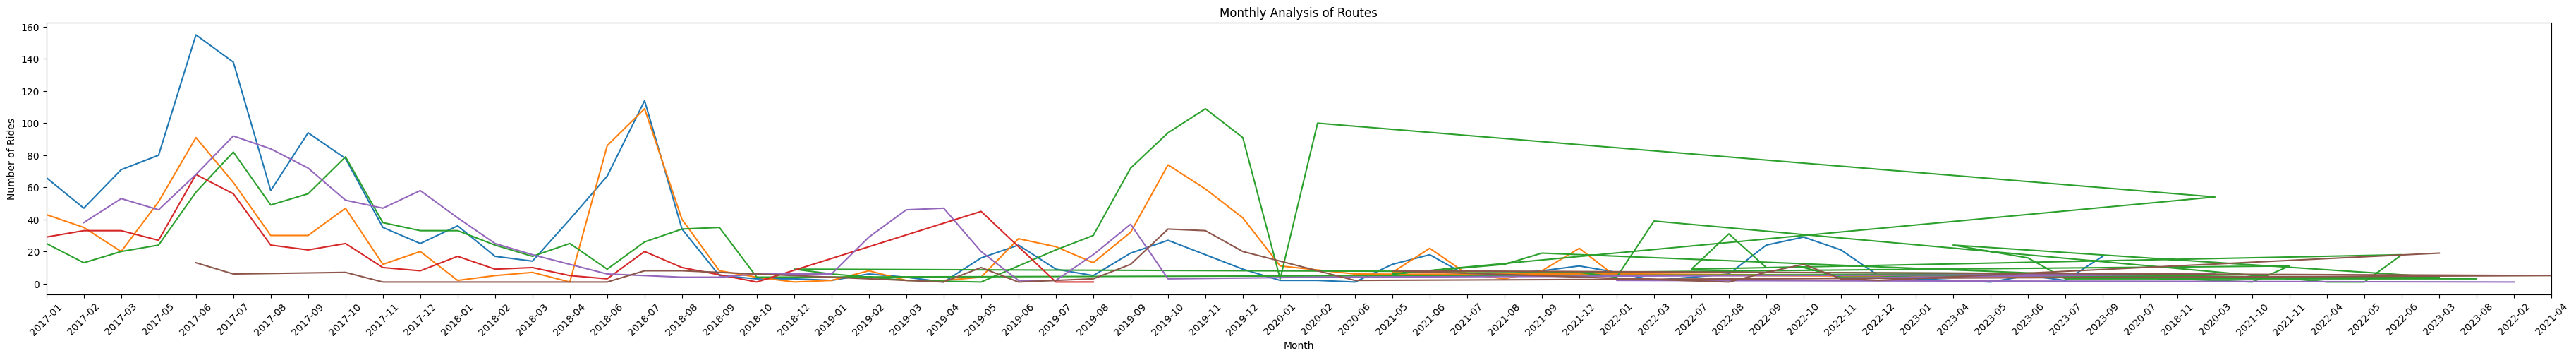

In [13]:
# Other Month Comparsion

# total VU Rides on WeGo - month to month comparison (February - April 2023)
print("Total Number of Vanderbilt Other Scans in the We Go Bus System (Clean):", df_other.shape[0])
print("Student VU Rides on WeGo - month to month comparison (2017 to Oct. 2023)")

# Group the data by 'Month_Year' and count the number of rides per month, for employees only
monthly_data = df_other.groupby('MONTH_YEAR').size().reset_index(name='RIDE_COUNT')
plot_all_months(monthly_data)

# Employee Route Comparsion - All Routes and Top 6 Routes
print("Employee Route Comparsion - All Routes and Top 6 Routes")
# Calculate the total ridership for each route per month - Using MONTH and RIDE_DATE FROM ABOVE
route_month_counts = df_other.groupby(['ROUTE', 'MONTH_YEAR']).size().reset_index(name='COUNT')

# Visualize the Data
plot_top_and_all_routes(route_month_counts)

In [14]:
# Mapping cell! - try 2017 and 2022 first

# Route 5 merged with route 3
# renumbered to route 75


# get the ridership data from 2022
# find all of the routes in 2017

# checking unique routes from the data

# creating the 2022 routes dictionary - from transitfeed GFTS
routes_2022 = {
    "23": "Dickerson Pike",
    "28": "Meridian",
    "3": "West End - White Bridge",
    "88": "Dickson",
    "89": "Springfield",
    "64": "Star Downtown Shuttle",
    "34": "Opry Mills",
    "86": "Smyrna - La Vergne",
    "87": "Gallatin",
    "84": "Murfreesboro",
    "25": "Midtown",
    "21": "Wedgewood",
    "22": "Bordeaux",
    "42": "St. Cecilia - Cumberland",
    "29": "Jefferson",
    "41": "Golden Valley",
    "77": "Thompson Wedgewood",
    "5": "West End - Bellevue",
    "4": "Shelby",
    "7": "Hillsboro",
    "6": "Lebanon Pike",
    "9": "Metrocenter",
    "8": "8th Avenue South",
    "76": "Madison",
    "75": "Midtown",
    "90": "Wego Star",
    "93": "Star West End Shuttle",
    "95": "Spring Hill Express",
    "94": "Clarksville Express",
    "79": "Skyline",
    "14": "Whites Creek",
    "17": "12th Avenue South",
    "19": "Herman",
    "18": "Airport",
    "56": "Gallatin Pike",
    "50": "Charlotte Pike",
    "52": "Nolensville Pike",
    "55": "Murfreesboro Pike"
}

# checking unique routes from the data

df_2022 = df[df['YEAR'] == 2022]
df_routes2022 = df_2022['ROUTE'].unique()


routes_2022 = list(routes_2022.keys())
routes_2022.sort()
print("Listed Routes:", routes_2022)
print("Number of Routes:", len(routes_2022))


# checking unique routes from the data
print("Unique Routes:", df_routes2022)
set_unique_routes2022 = set(df_routes2022)
print("Number of Unique Routes:", len(df_routes2022))
# seeing what routes are missing from the dictionary
missing_routes_set2022 = set_unique_routes2022 - set(routes_2022)
missing_routes2022 = list(missing_routes_set2022)
missing_routes2022.sort()
print("Missing Routes:", missing_routes2022)
print("Number of Missing Routes:", len(missing_routes2022))



# get the total amount of ridership for each route in 2022
# Calculate the total ridership for each route per month - Using MONTH and RIDE_DATE FROM ABOVE
total_route_month_count2022 = df_2022.groupby(['ROUTE']).size().reset_index(name='COUNT')


# Calculate the total ridership for each route
route_ridership2022 = total_route_month_count2022.groupby('ROUTE')['COUNT'].sum().reset_index(name='RIDERSHIP')
# Find the top 6 routes by total ridership
top_routes2022 = route_ridership2022.sort_values('RIDERSHIP', ascending=False)
top_6_routes2022 = route_ridership2022.sort_values('RIDERSHIP', ascending=False).head(6)
print("Top 6 Routes by Ridership from 2022")
print(top_6_routes2022)
# check if the math adds up - see if all the routes combined add up to the total ridership
print("Total Ridership for 2022")
print(route_ridership2022['RIDERSHIP'].sum())

Listed Routes: ['14', '17', '18', '19', '21', '22', '23', '25', '28', '29', '3', '34', '4', '41', '42', '5', '50', '52', '55', '56', '6', '64', '7', '75', '76', '77', '79', '8', '84', '86', '87', '88', '89', '9', '90', '93', '94', '95']
Number of Routes: 38
Unique Routes: [    47      3     50     56      7     52      8     18     23     55
     75     34     22     42      4     77     19     17     14     29
     76     28     84     87      6      9     79     95     48     93
     41     89      5     94     88     78     99  52204     86     33
   8700    999   5507  22502      0    303    312   3001    401  47018
    315  21979 505002      1   5001  52006   3202   1801  48002   4101
  47112  47309 878705   5214   5204   9201    800  47305   1703    890
   2312  47503  47007  19002   8705   8701   6502   8800  47504   5004
  47009    314   8702   2301  11090  47308  47025   5206     98   2802
  47605    702    701   5608    304  18002  47304  48101   1938  41410
  75101   8201   

In [15]:
# Step 1: Load the data
ridership_df2022 = total_route_month_count2022
gtfs_feed2022 = gk.read_feed('../gtfs', dist_units='m')

# Load the GTFS routes and shapes
routes_df2022 = gtfs_feed2022.routes
shapes_df2022 = gtfs_feed2022.shapes
trips_df2022 = gtfs_feed2022.trips

ridership_df2022['ROUTE'] = ridership_df2022['ROUTE'].astype(str)
routes_df2022['route_id'] = routes_df2022['route_id'].astype(str)
trips_df2022['route_id'] = trips_df2022['route_id'].astype(str)

# Step 2: Process GTFS shapes
shapes_gdf2022 = shapes_df2022.groupby('shape_id').apply(
    lambda x: LineString(zip(x.shape_pt_lon, x.shape_pt_lat))
).reset_index().rename(columns={0: 'geometry'})

shapes_gdf2022 = gpd.GeoDataFrame(shapes_gdf2022, geometry='geometry')


# Step 3: Merge ridership data with GTFS routes

merged_df2022 = pd.merge(routes_df2022, ridership_df2022, left_on='route_id', right_on='ROUTE')

# Merge the merged_df with trips_df to get shape_id associated with each route.
route_shape_df2022 = pd.merge(merged_df2022, trips_df2022[['route_id', 'shape_id']], on='route_id')


# Since there can be multiple trips with the same shape_id, you want to drop duplicates.
route_shape_df2022 = route_shape_df2022.drop_duplicates(subset=['shape_id'])

ridership_shapes_gdf2022 = pd.merge(route_shape_df2022, shapes_gdf2022, on='shape_id')

num_unique_routes = ridership_shapes_gdf2022['route_id'].nunique()
# print(ridership_shapes_gdf2022['route_id'].unique())

# remove the routes that are not unique in the ridership_shapes_gdf and the routes_2022 and only keep the ridership and route number
actual_route_ridership = ridership_shapes_gdf2022[ridership_shapes_gdf2022['route_id'].isin(routes_2022)]
# get the route numbers and ridership from actual_route_ridership
actual_route_ridership = actual_route_ridership[['route_id', 'COUNT']]
# remove duplicates
actual_route_ridership = actual_route_ridership.drop_duplicates(subset=['route_id'])
actual_route_ridership = actual_route_ridership.reset_index(drop=True)
# sort actual_route_ridership by ridership
actual_route_ridership = actual_route_ridership.sort_values(by=['COUNT'], ascending=False)
# print(actual_route_ridership)

In [16]:
num_colors = num_unique_routes
color_palette = sns.color_palette("bright", max(num_unique_routes, len(sns.color_palette("bright"))))

m = folium.Map(location=[36.1627, -86.7816], zoom_start=12, tiles='CartoDB dark_matter')

# Sort the ridership dataframe by 'COUNT' in descending order and remove duplicates
unique_ridership_df2022 = ridership_shapes_gdf2022.sort_values('COUNT', ascending=False).drop_duplicates('route_id')

# Select the top N unique routes based on ridership 'COUNT'
top_n_routes = 10  # Set this to the number of top routes you want to label
top_routes = unique_ridership_df2022.head(top_n_routes)

# generate the set of top routes
top_routes_set = set(top_routes['route_id'])
color_map = {}
# Track labeled routes
labeled_routes = set()
# display(ridership_shapes_gdf2022)
for i, row in ridership_shapes_gdf2022.iterrows():
    # Get the midpoint of the route for placing the label
    color_index = i % len(color_palette) 
    color = mcolors.rgb2hex(color_palette[color_index])
    coords = row['geometry'].coords[:]
    midpoint = coords[len(coords) // 2]
    
    # Normalize the weight and ensure a minimum weight
    min_weight = 5  # Set a minimum weight for visibility
    weight = max(row['COUNT'] / ridership_shapes_gdf2022['COUNT'].max() * 15, min_weight)
    
    line = folium.PolyLine(
        locations=[(point[1], point[0]) for point in row['geometry'].coords],
        weight= weight,
        color = color,  
        opacity=0.8,  # Ensure lines are not too opaque
        tooltip=f'Route {row["route_short_name"]}'
    ).add_to(m)
    color_map[row["route_short_name"]] = color
    line.add_child(folium.Popup(f'{row["route_short_name"]}: {row["COUNT"]} scans'))
    # Create label text
    label_text = f'Route {row["route_short_name"]}: {row["COUNT"]} scans'

    # Improved label with shadow for better visibility
    label_html = f'''
    <div style="font-size: 12pt; color : white; text-shadow: 2px 2px 4px #000000;">
        {label_text}
    </div>
    '''
    # Check if the current route is one of the top routes
    if row['route_id'] not in labeled_routes and row['route_id'] in top_routes_set:
        labeled_routes.add(row['route_id'])
        # Add labels only for the top routes
        label_html = f'''
        <div style="font-size: 12pt; color : white; text-shadow: 2px 2px 4px #000000;">
            Route {row["route_short_name"]}: {row["COUNT"]} scans
        </div>
        '''
        label_coords = (midpoint[1], midpoint[0])
        folium.map.Marker(
            label_coords,
            icon=DivIcon(
                icon_size=(200,36),
                icon_anchor=(0,0),
                html=label_html,
            )
        ).add_to(m)

# HTML for the table
table_html = f'''
<div style="position: fixed; bottom: 50px; left: 50px; width: 300px; height: 200px; 
            background-color: white; border: 2px solid black; z-index:9999; font-size:14px; overflow-y: scroll;">
    <table border="1" style="border-collapse: collapse; width: 100%;">
        <tr>
            <th>ROUTE NUMBER</th>
            <th>RIDERSHIP SCANS</th>
            <tr><td style="color: {color_map['7']}">7</td><td style="color: {color_map['7']}">99117</td></tr>
            <tr><td style="color: {color_map['3']}">3</td><td style="color: {color_map['3']}">56601</td></tr>
            <tr><td style="color: {color_map['55']}">55</td><td style="color: {color_map['55']}">17124</td></tr>
            <tr><td style="color: {color_map['56']}">56</td><td style="color: {color_map['56']}">13764</td></tr>
            <tr><td style="color: {color_map['50']}">50</td><td style="color: {color_map['50']}">9127</td></tr>
            <tr><td style="color: {color_map['23']}">23</td><td style="color: {color_map['23']}">8130</td></tr>
            <tr><td style="color: {color_map['52']}">52</td><td style="color: {color_map['52']}">7341</td></tr>
            <tr><td style="color: {color_map['22']}">22</td><td style="color: {color_map['22']}">6038</td></tr>
            <tr><td style="color: {color_map['75']}">75</td><td style="color: {color_map['75']}">4927</td></tr>
            <tr><td style="color: {color_map['77']}">77</td><td style="color: {color_map['77']}">4909</td></tr>
            <tr><td style="color: {color_map['4']}">4</td><td style="color: {color_map['4']}">4709</td></tr>
            <tr><td style="color: {color_map['19']}">19</td><td style="color: {color_map['19']}">4332</td></tr>
            <tr><td style="color: {color_map['8']}">8</td><td style="color: {color_map['8']}">3616</td></tr>
            <tr><td style="color: {color_map['87']}">87</td><td style="color: {color_map['87']}">2824</td></tr>
            <tr><td style="color: {color_map['17']}">17</td><td style="color: {color_map['17']}">2818</td></tr>
            <tr><td style="color: {color_map['42']}">42</td><td style="color: {color_map['42']}">2683</td></tr>
            <tr><td style="color: {color_map['28']}">28</td><td style="color: {color_map['28']}">2640</td></tr>
            <tr><td style="color: {color_map['6']}">6</td><td style="color: {color_map['6']}">2405</td></tr>
            <tr><td style="color: {color_map['14']}">14</td><td style="color: {color_map['14']}">2356</td></tr>
            <tr><td style="color: {color_map['18']}">18</td><td style="color: {color_map['18']}">1798</td></tr>
            <tr><td style="color: {color_map['29']}">29</td><td style="color: {color_map['29']}">1798</td></tr>
            <tr><td style="color: {color_map['84']}">84</td><td style="color: {color_map['84']}">1540</td></tr>
            <tr><td style="color: {color_map['95']}">95</td><td style="color: {color_map['95']}">1465</td></tr>
            <tr><td style="color: {color_map['34']}">34</td><td style="color: {color_map['34']}">1016</td></tr>
            <tr><td style="color: {color_map['9']}">9</td><td style="color: {color_map['9']}">951</td></tr>
            <tr><td style="color: {color_map['76']}">76</td><td style="color: {color_map['76']}">883</td></tr>
            <tr><td style="color: {color_map['89']}">89</td><td style="color: {color_map['89']}">778</td></tr>
            <tr><td style="color: {color_map['94']}">94</td><td style="color: {color_map['94']}">526</td></tr>
            <tr><td style="color: {color_map['41']}">41</td><td style="color: {color_map['41']}">211</td></tr>
            <tr><td style="color: {color_map['79']}">79</td><td style="color: {color_map['79']}">195</td></tr>
            <tr><td style="color: {color_map['88']}">88</td><td style="color: {color_map['88']}">97</td></tr>
            <tr><td style="color: {color_map['93']}">93</td><td style="color: {color_map['93']}">78</td></tr>
            <tr><td style="color: {color_map['86']}">86</td><td style="color: {color_map['86']}">39</td></tr>
            <tr><td style="color: {color_map['64']}">64</td><td style="color: {color_map['64']}">3</td></tr>
    </table>
</div>
'''

# Position for the table
position = (36.147392, -87.025980)

# Add the table as a popup to a marker
table_marker = Marker(location=position, icon=folium.DivIcon(html=table_html), popup=table_html)
m.add_child(table_marker)

folium.LayerControl().add_to(m)

m.save('nashville_vanderbilt2022_bus_routes.html')
# Add a title to the HTML file
with open('nashville_vanderbilt2022_bus_routes.html', 'r') as file:
    data = file.read()

title_html = '''
     <h3 align="center" style="font-size:20px"><b>Map of 2022 Vanderbilt Ridership Scans</b></h3>
     '''
data = data.replace('<body>', '<body> \n' + title_html)

with open('nashville_vanderbilt2022_bus_routes.html', 'w') as file:
    file.write(data)

In [44]:
print("Total Number of Vanderbilt Scans in the We Go Bus System (Clean):", df_cleaned.shape[0])

# keep only the 2022 scans
df_2022 = df_cleaned[df_cleaned['YEAR'] == 2022]
print("Total Number of Vanderbilt Scans in the We Go Bus System (2022):", df_2022.shape[0])


# sort the 2022 scans by id
df_2022 = df_2022.sort_values(by=['CAMPUS_ID'])
df_2022 = df_2022.reset_index(drop=True)
# remove the RTA_COUNT and WEGO_COUNT columns
df_2022 = df_2022.drop(columns=['RTA_COUNT', 'WEGO_COUNT'])
# count how many each person scanned, and keep the first and last name as well
df_2022List = df_2022.groupby(['CAMPUS_ID', 'FIRST_NAME','LAST_NAME','EMPLOYEE_OR_STUDENT']).size().reset_index(name='COUNT')
# create a routes category for each person
df_2022List['ROUTES'] = df_2022List['CAMPUS_ID'].map(df_2022.groupby('CAMPUS_ID')['ROUTE'].apply(list))

# only keep the unique routes in the routes
df_2022List['ROUTES'] = df_2022List['ROUTES'].apply(lambda x: list(set(x)))

# print(df_2022List.to_string())
df_2022List = df_2022List.drop_duplicates(subset=['CAMPUS_ID'])
# sort the 2022 scans by id
df_2022List = df_2022List.sort_values(by=['COUNT'], ascending=False)
print("Total Number of Unique Vanderbilt Scans in the We Go Bus System (2022):", len(df_2022List['CAMPUS_ID'].unique()))


Total Number of Vanderbilt Scans in the We Go Bus System (Clean): 1181180
Total Number of Vanderbilt Scans in the We Go Bus System (2022): 171343
Total Number of Unique Vanderbilt Scans in the We Go Bus System (2022): 4679


In [46]:
# get the top 1000 riders from the 2022 data and put them into a csv file and put into the csv folder
df_2022ListHead = df_2022List.head(1000)
# print(df_2022ListHead.head())
# add the used routes by the VUNetIDs of the top 1000 riders
# df_2022ListHead['ROUTES'] = ""

# # get the routes that the top 1000 riders used
# # loop through the top 1000 riders
# for index, row in df_2022ListHead.iterrows():
#     # get the VUNetID
#     VUNetID = row['CAMPUS_ID']
#     # get the rows that have the VUNetID
#     df_VUNetID = df_2022ListHead[df_2022ListHead['CAMPUS_ID'] == VUNetID]
#     # get the routes that the VUNetID used
#     routes = df_VUNetID['ROUTES'].unique()
#     print(df_VUNetID['ROUTES'].unique())
#     # add the routes to the df_2022List
#     routes.sort()
#     print(routes)
#     df_2022ListHead.at[index, 'ROUTES'] = routes


df_2022ListHead.to_csv('top1000riders2022.csv', index=False)


In [19]:
bins = [0, 1, 5, 10, 20, 50, 100, 500, 1192]
labels = ['1 ride', '2-5 rides', '6-10 rides', '11-20 rides', '21-50 rides', '51-100 rides', '101-500 rides', '501-1192 rides']
df_2022List['ridership_category'] = pd.cut(df_2022List['COUNT'], bins=bins, labels=labels, include_lowest=True)
# keep it in the order of the labels
category_counts = df_2022List['ridership_category'].value_counts()

print("Category Counts in Order of Labels (2022)")
for label in labels:
    print(label, ' : ', category_counts[label])


Category Counts in Order of Labels (2022)
1 ride  :  750
2-5 rides  :  1639
6-10 rides  :  600
11-20 rides  :  527
21-50 rides  :  485
51-100 rides  :  273
101-500 rides  :  354
501-1192 rides  :  51


C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\1320780844.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2022Uncleaned['WEEK'] = df2022Uncleaned['RIDE_DATE'].dt.strftime('%U')


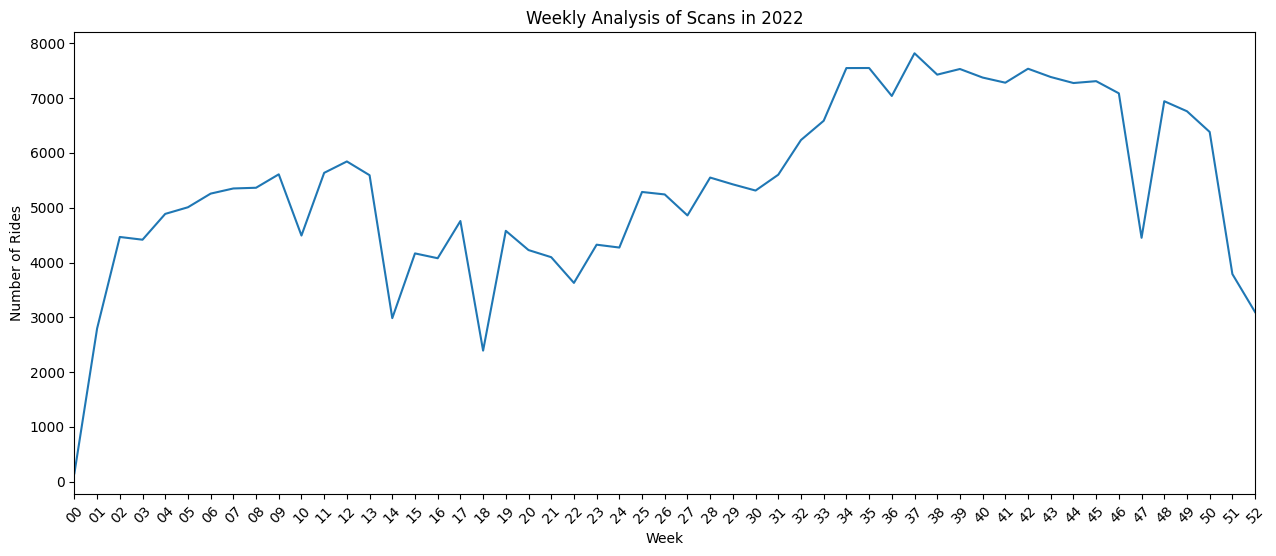

In [20]:
# graph ridership per day for 2022

df2022Uncleaned = df[df['YEAR'] == 2022]
df2022Uncleaned['WEEK'] = df2022Uncleaned['RIDE_DATE'].dt.strftime('%U')
df_2022UnCleanedList = df2022Uncleaned.groupby(['WEEK']).size().reset_index(name='COUNT')

# df2022Uncleaned['DATE_MONTH_YEAR'] = df2022Uncleaned['RIDE_DATE'].dt.strftime('%Y-%m-%d')
# df_2022UnCleanedList = df2022Uncleaned.groupby(['DATE_MONTH_YEAR']).size().reset_index(name='COUNT')
# df_2022UnCleanedList = df_2022UnCleanedList.sort_values(by=['COUNT'], ascending=False)

# plot this data
# create a line graph
plt.figure(figsize=(10, 6))
plt.plot(df_2022UnCleanedList['WEEK'], df_2022UnCleanedList['COUNT'])
plt.xlabel('Week')
plt.ylabel('Number of Rides')
plt.title('Weekly Analysis of Scans in 2022')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*(len(df_2022UnCleanedList))+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

# plt.savefig(__file__+".png")
plt.show()

C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\235278316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['RIDE_DATE'] = pd.to_datetime(df_cleaned['RIDE_DATE'])
C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\235278316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Hour'] = df_cleaned['RIDE_DATE'].dt.hour
C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\235278316.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

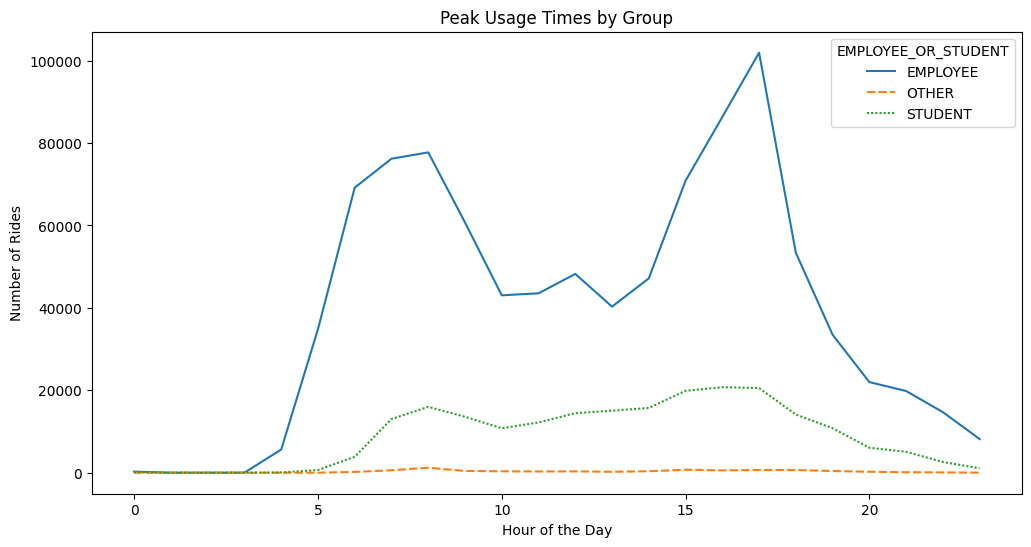

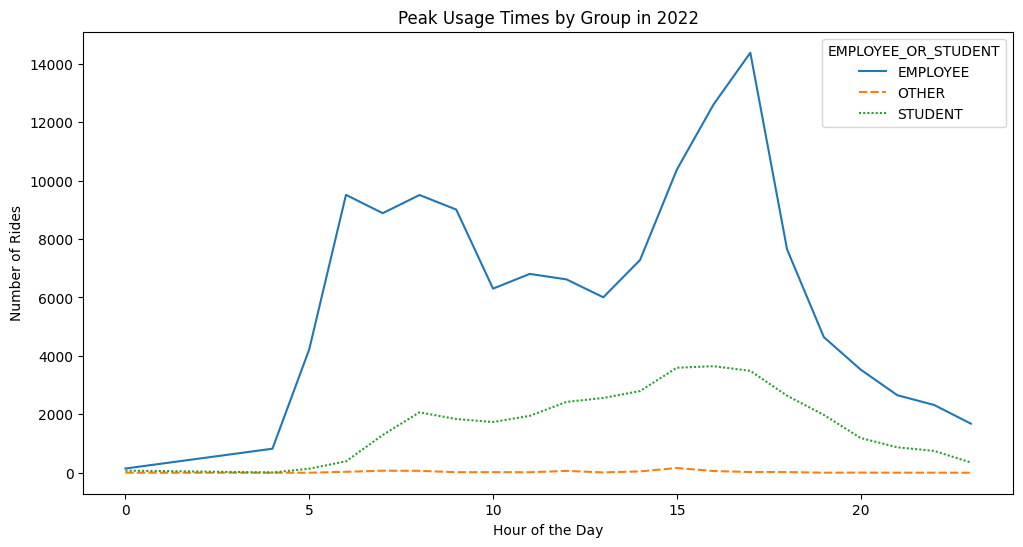

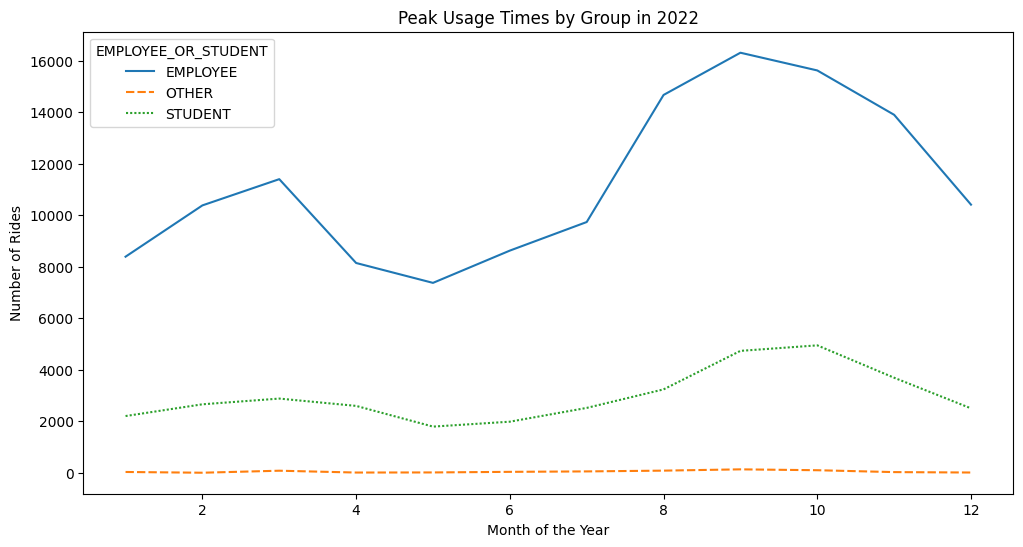

<Figure size 1200x600 with 0 Axes>

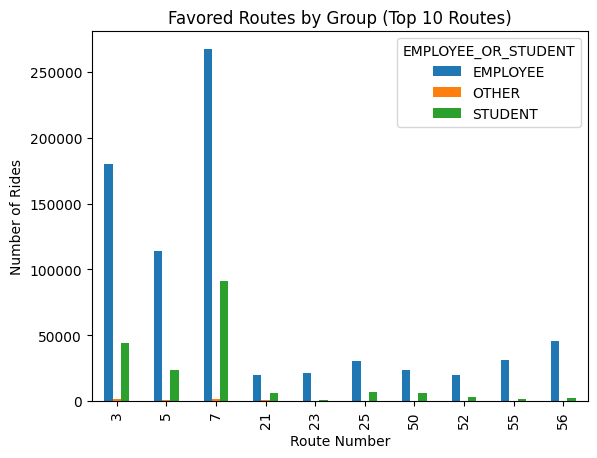

<Figure size 1200x600 with 0 Axes>

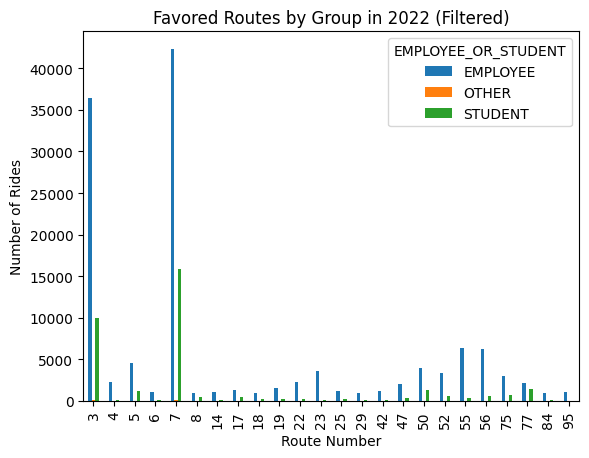

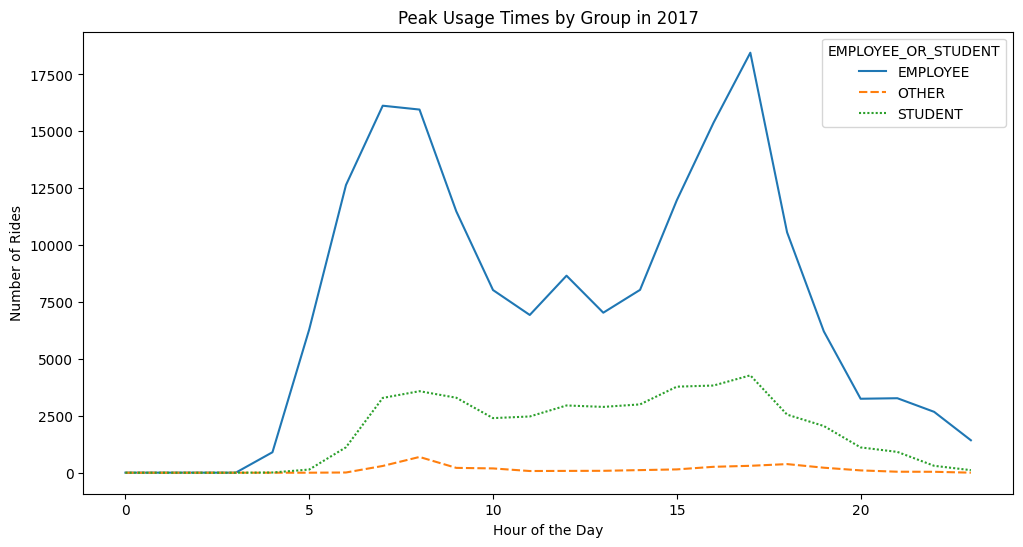

In [21]:
# Convert 'Ride_Date' to a datetime object
df_cleaned['RIDE_DATE'] = pd.to_datetime(df_cleaned['RIDE_DATE'])

# Extract time, day, month, and year from 'Ride_Date'
df_cleaned['Hour'] = df_cleaned['RIDE_DATE'].dt.hour
df_cleaned['Day'] = df_cleaned['RIDE_DATE'].dt.day
df_cleaned['Month'] = df_cleaned['RIDE_DATE'].dt.month
df_cleaned['Year'] = df_cleaned['RIDE_DATE'].dt.year
df_cleaned['Weekday'] = df_cleaned['RIDE_DATE'].dt.dayofweek 

rides_per_group = df_cleaned.groupby('EMPLOYEE_OR_STUDENT')['RIDE_DATE'].count()
#print("Rides Per Group")
#print(rides_per_group)

# Aggregate rides by hour and status
peak_usage = df_cleaned.groupby(['Hour', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
#print("Peak Usage Times by Group")
#print(peak_usage)

# Plot for peak usage
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_usage)
plt.title('Peak Usage Times by Group')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.show()

# Aggregate rides by route and status for the year 2022
df_2022 = df_cleaned[df_cleaned['YEAR'] == 2022]
peak_usage2022 = df_2022.groupby(['Hour', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
# print("Peak Usage Time by Group in 2022")
# print(peak_usage2022)

# Plot for peak usage 2022
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_usage2022)
plt.title('Peak Usage Times by Group in 2022')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.show()


peak_usageMonthly2022 = df_2022.groupby(['Month', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
# print("Peak Usage Time by Group in 2022")
# print(peak_usage2022)

# Plot for peak usage 2022
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_usageMonthly2022)
plt.title('Peak Usage Times by Group in 2022')
plt.xlabel('Month of the Year')
plt.ylabel('Number of Rides')
plt.show()



# Aggregate the total number of rides per route
total_rides_per_route = df_cleaned.groupby('ROUTE').size()
# select the top 5 routes
top_5_routes = total_rides_per_route.sort_values(ascending=False).head(10).index.tolist()
significant_routes = total_rides_per_route[total_rides_per_route >= 5000].index.tolist()
# Filter the main dataset
filtered_data = df_cleaned[df_cleaned['ROUTE'].isin(top_5_routes)]
# Re-count the number of rides per route for each status group on the filtered data
favored_routes_filtered = filtered_data.groupby(['ROUTE', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
# If you wish to visualize it:
plt.figure(figsize=(12, 6))
favored_routes_filtered.plot(kind='bar')
plt.title('Favored Routes by Group (Top 10 Routes)')
plt.xlabel('Route Number')
plt.ylabel('Number of Rides')
plt.show()

# Aggregate the total number of rides per route in 2022
df_2022 = df_cleaned[df_cleaned['YEAR'] == 2022]
total_rides_per_route2022 = df_2022.groupby('ROUTE').size()
# Filter out routes with less than 10 total rides
significant_routes2022 = total_rides_per_route2022[total_rides_per_route2022 >= 1000].index.tolist()
# Filter the main dataset
filtered_data2022 = df_2022[df_2022['ROUTE'].isin(significant_routes2022)]
# Re-count the number of rides per route for each status group on the filtered data
favored_routes_filtered2022 = filtered_data2022.groupby(['ROUTE', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
# If you wish to visualize it:
plt.figure(figsize=(12, 6))
favored_routes_filtered2022.plot(kind='bar')
plt.title('Favored Routes by Group in 2022 (Filtered)')
plt.xlabel('Route Number')
plt.ylabel('Number of Rides')
plt.show()

# Aggregate the total number of rides per route in 2022
df_2017 = df_cleaned[df_cleaned['YEAR'] == 2017]
peak_usage2017 = df_2017.groupby(['Hour', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
# print("Peak Usage Time by Group in 2022")
# print(peak_usage2022)

# Plot for peak usage 2022
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_usage2017)
plt.title('Peak Usage Times by Group in 2017')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.show()



C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\333966489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Day_Type'] = df_cleaned['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\333966489.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Day_Type']  = filtered_data['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')


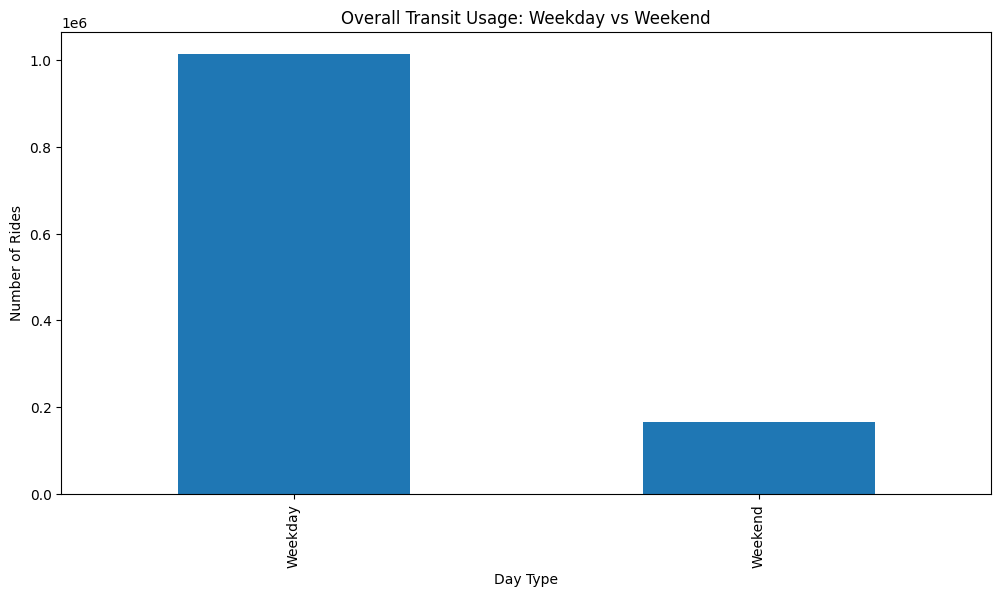

<Figure size 1200x600 with 0 Axes>

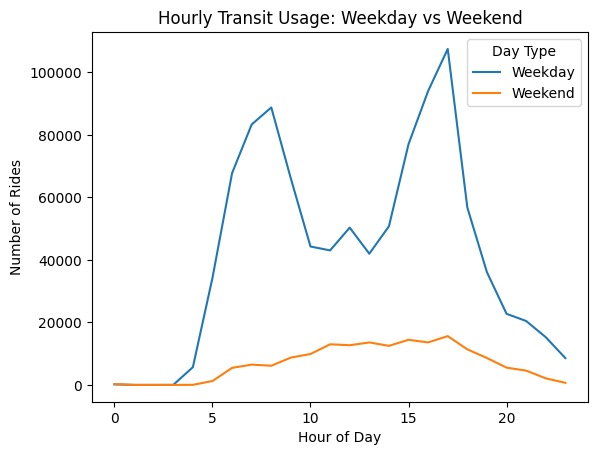

<Figure size 1200x600 with 0 Axes>

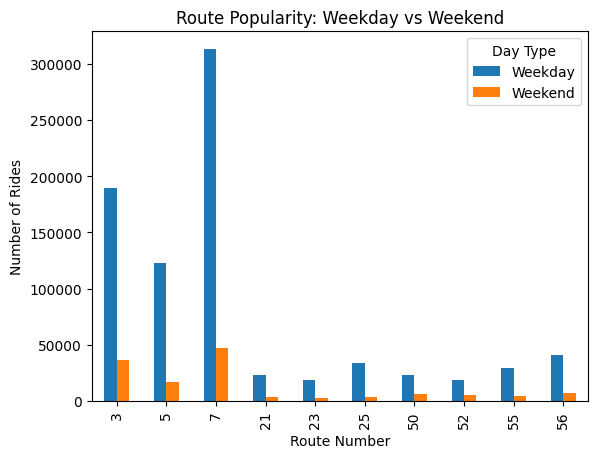

C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\333966489.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Day_Type'] = df_2022['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
C:\Users\syeda\AppData\Local\Temp\ipykernel_32320\333966489.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data2022['Day_Type']  = filtered_data2022['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')


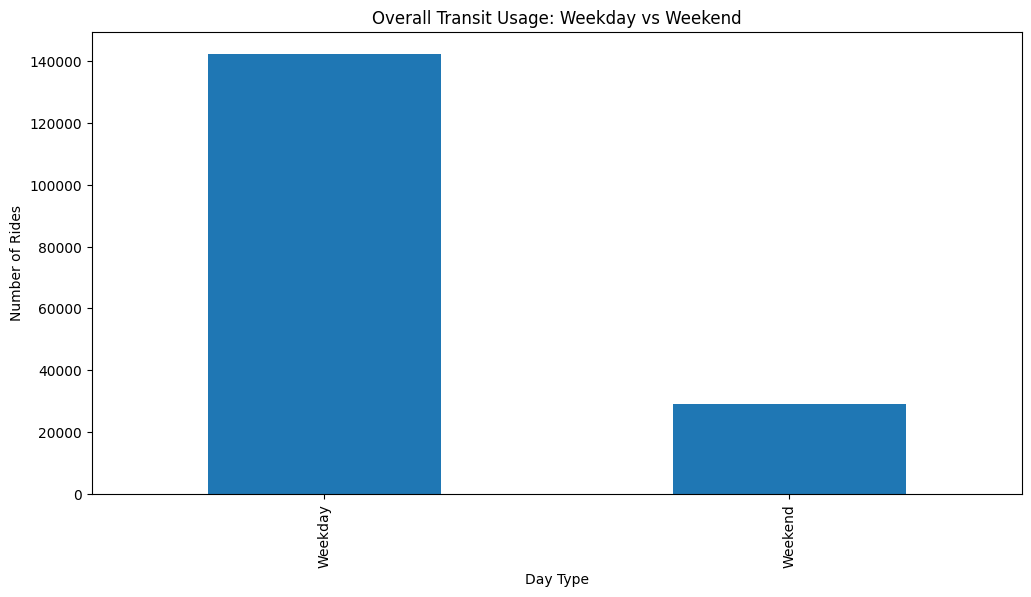

<Figure size 1200x600 with 0 Axes>

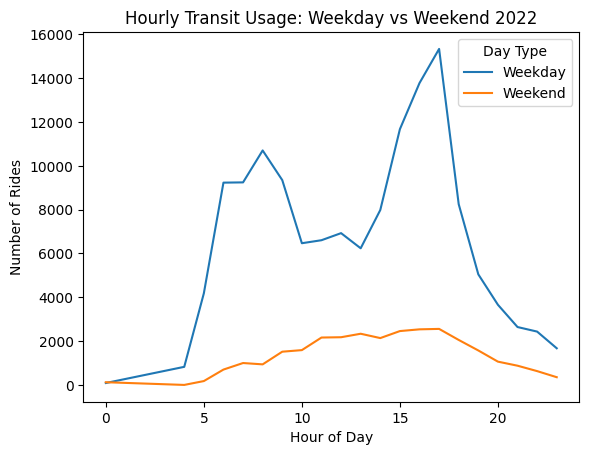

<Figure size 1200x600 with 0 Axes>

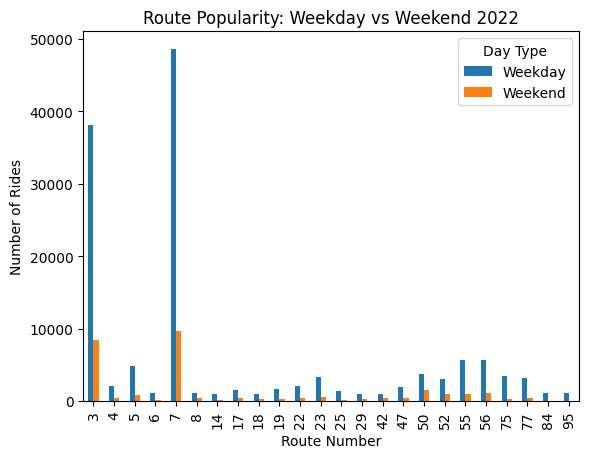

In [22]:
# weekday analysis vs weekend analysis
df_cleaned['Day_Type'] = df_cleaned['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
weekday_weekend_rides = df_cleaned.groupby('Day_Type').size()

# Group by day type and hour, then count rides
hourly_rides = df_cleaned.groupby(['Day_Type', 'Hour']).size().unstack(fill_value=0)

filtered_data['Day_Type']  = filtered_data['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by day type and route, then count rides
route_popularity = filtered_data.groupby(['Day_Type', 'ROUTE']).size().unstack(fill_value=0)

# Plot for overall usage
plt.figure(figsize=(12, 6))
weekday_weekend_rides.plot(kind='bar')
plt.title('Overall Transit Usage: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Number of Rides')
plt.show()

# Plot for hourly rides
plt.figure(figsize=(12, 6))
hourly_rides.T.plot(kind='line')  # Transpose for better plotting
plt.title('Hourly Transit Usage: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.legend(title='Day Type')
plt.show()

# Plot for route popularity
plt.figure(figsize=(12, 6))
route_popularity.T.plot(kind='bar')  # Transpose for better plotting
plt.title('Route Popularity: Weekday vs Weekend')
plt.xlabel('Route Number')
plt.ylabel('Number of Rides')
plt.legend(title='Day Type')
plt.show()


# generate this for 2022
df_2022['Day_Type'] = df_2022['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
weekday_weekend_rides2022 = df_2022.groupby('Day_Type').size()

# Group by day type and hour, then count rides
hourly_rides2022 = df_2022.groupby(['Day_Type', 'Hour']).size().unstack(fill_value=0)

filtered_data2022['Day_Type']  = filtered_data2022['RIDE_DATE'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by day type and route, then count rides
route_popularity2022 = filtered_data2022.groupby(['Day_Type', 'ROUTE']).size().unstack(fill_value=0)

# Plot for overall usage
plt.figure(figsize=(12, 6))
weekday_weekend_rides2022.plot(kind='bar')
plt.title('Overall Transit Usage: Weekday vs Weekend')
plt.xlabel('Day Type')
plt.ylabel('Number of Rides')
plt.show()

# Plot for hourly rides
plt.figure(figsize=(12, 6))
hourly_rides2022.T.plot(kind='line')  # Transpose for better plotting
plt.title('Hourly Transit Usage: Weekday vs Weekend 2022')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.legend(title='Day Type')
plt.show()

# Plot for route popularity
plt.figure(figsize=(12, 6))
route_popularity2022.T.plot(kind='bar')  # Transpose for better plotting
plt.title('Route Popularity: Weekday vs Weekend 2022')
plt.xlabel('Route Number')
plt.ylabel('Number of Rides')
plt.legend(title='Day Type')
plt.show()

EMPLOYEE_OR_STUDENT  EMPLOYEE  OTHER  STUDENT
Day_Type                                     
Weekday                835066   6103   173462
Weekend                122258   1349    42942


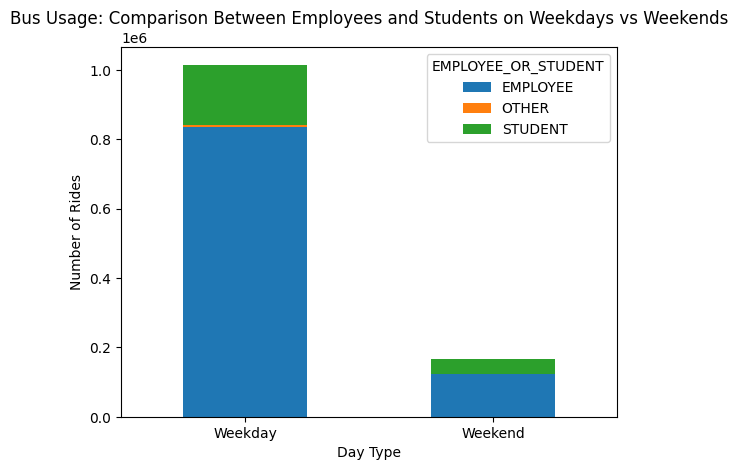

EMPLOYEE_OR_STUDENT  EMPLOYEE  OTHER  STUDENT
Day_Type                                     
Weekday                115101    581    26654
Weekend                 19861     30     9116


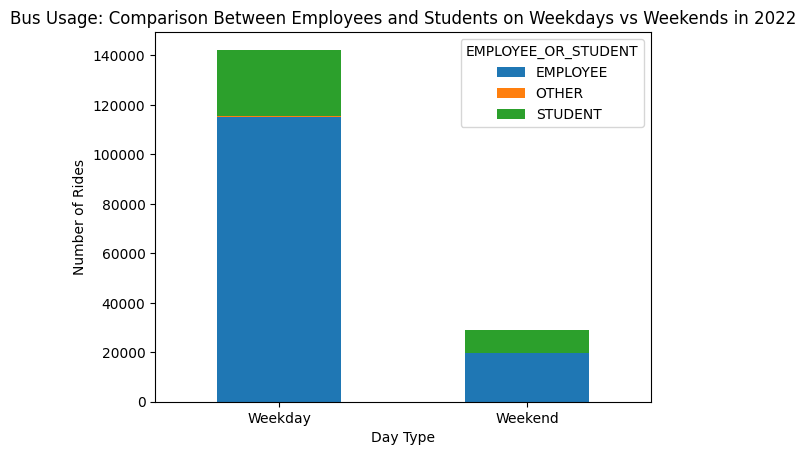

In [23]:
usage_by_day_type_and_status = df_cleaned.groupby(['Day_Type', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
print(usage_by_day_type_and_status)

# Plotting the data
usage_by_day_type_and_status.plot(kind='bar', stacked=True)
plt.title('Bus Usage: Comparison Between Employees and Students on Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.show()

# do this for 2022
usage_by_day_type_and_status2022 = df_2022.groupby(['Day_Type', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
print(usage_by_day_type_and_status2022)
# Plotting the data
usage_by_day_type_and_status2022.plot(kind='bar', stacked=True)
plt.title('Bus Usage: Comparison Between Employees and Students on Weekdays vs Weekends in 2022')
plt.xlabel('Day Type')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.show()


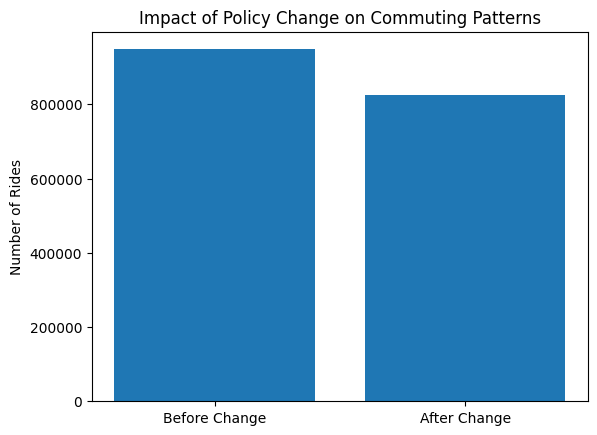

In [24]:
# If you have specific dates for policy changes, you can filter data around those dates and compare
# vanderbilt covid lock down/cancellation started 
before_policy_change = df[df['RIDE_DATE'] < '2020-03-11']
after_policy_change = df[df['RIDE_DATE'] >= '2020-03-11']

# Compare the number of rides before and after the policy change
rides_before_change = before_policy_change['RIDE_DATE'].count()
rides_after_change = after_policy_change['RIDE_DATE'].count()

# Comparing rides before and after a policy change
plt.bar(['Before Change', 'After Change'], [rides_before_change, rides_after_change])
plt.title('Impact of Policy Change on Commuting Patterns')
plt.ylabel('Number of Rides')
plt.show()

Number of Unique Trips: 10238


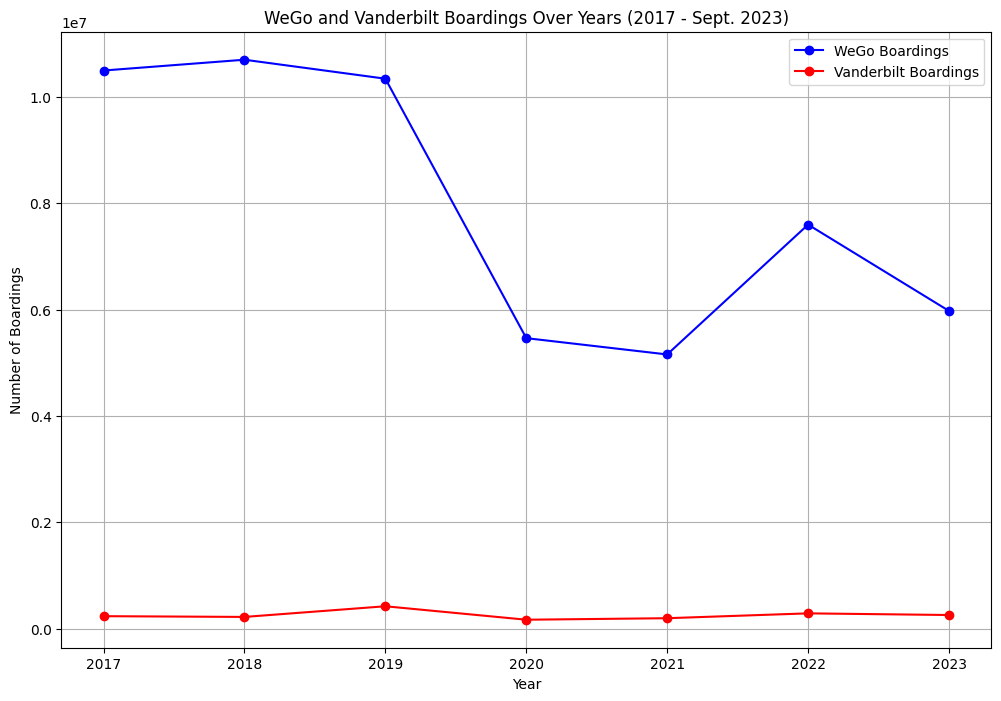

In [25]:
#TODO: CLIMATE RELATED ANALYSIS

# estimating the total number of buses in WeGo's fleet

unique_trips = trips_df2022['trip_id'].nunique()
print("Number of Unique Trips:", unique_trips)


# plotting Vanderbilt Scans vs. WeGo Scans
bus_rides = {
    "Year": [2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "WeGo Boardings": [10496400, 10699500, 10342500, 5462600, 5155800, 7598100, 5974500],
    "Vanderbilt Boardings": [232946, 218884, 419448, 166313, 194829, 286060, 254912]
}

df_bus_rides = pd.DataFrame(bus_rides)
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_bus_rides['Year'], df_bus_rides['WeGo Boardings'], marker='o', color='b', label='WeGo Boardings')
plt.plot(df_bus_rides['Year'], df_bus_rides['Vanderbilt Boardings'], marker='o', color='r', label='Vanderbilt Boardings')
plt.title('WeGo and Vanderbilt Boardings Over Years (2017 - Sept. 2023)')
plt.xlabel('Year')
plt.ylabel('Number of Boardings')
plt.xticks(df_bus_rides['Year'])
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Total Addressable Market Analysis, using data in 2022
total_students = 13710
total_employees = 9107

total_addressable_market = total_students + total_employees

# find the total number of unique users during the 2022-2023 school year
# find the total number of unique users during the 2022-2023 school year
df_2022 = df_cleaned[df_cleaned['YEAR'] == 2022]

df_2022List = df_2022.groupby(['CAMPUS_ID']).size().reset_index(name='COUNT')
actual_transit_riders = len(df_2022List['CAMPUS_ID'].unique())

penetration_rate = (actual_transit_riders / total_addressable_market) * 100

print(f"Penetration Rate: {penetration_rate}%")

Penetration Rate: 20.50663978612438%


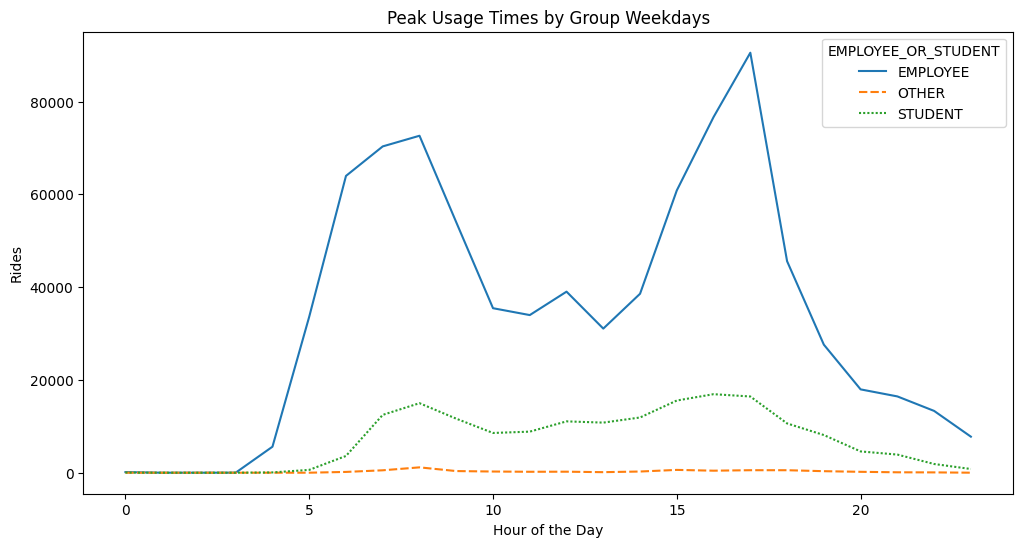

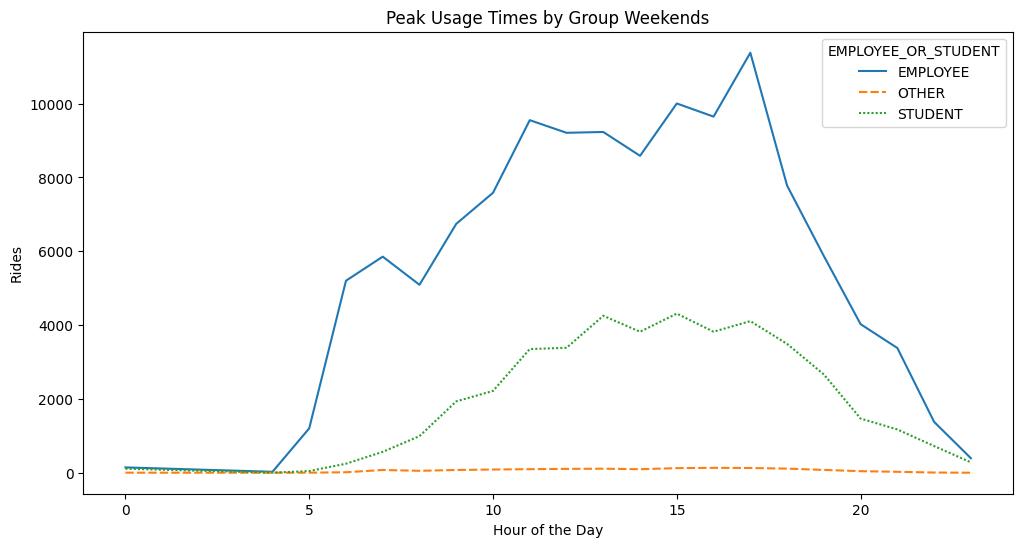

In [27]:
# generate a line graph that shows employee vs student vs other transit ridership on the weekdays

# Aggregate rides by hour and status WEEKDAYS

df_cleaned_weekdays = df_cleaned[df_cleaned['Weekday'] < 5]

peak_usage_weekdays = df_cleaned_weekdays.groupby(['Hour', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
#print("Peak Usage Times by Group")
#print(peak_usage)

# Plot for peak usage
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_usage_weekdays)
plt.title('Peak Usage Times by Group Weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Rides')
plt.show()

df_cleaned_weekends = df_cleaned[df_cleaned['Weekday'] >= 5]

peak_usage_weekends = df_cleaned_weekends.groupby(['Hour', 'EMPLOYEE_OR_STUDENT']).size().unstack(fill_value=0)
#print("Peak Usage Times by Group")
#print(peak_usage)

# Plot for peak usage
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_usage_weekends)
plt.title('Peak Usage Times by Group Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Rides')
plt.show()
